In [17]:
import random
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from pycaret.regression import * 
import warnings
warnings.filterwarnings(action='ignore') 

In [18]:
seed=42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [19]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
building_info = pd.read_csv('./building_info.csv')

In [20]:
train_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [21]:
# Extract date information from the '일시' column
train_df['날짜'] = train_df['일시'].str.split(' ').str[0]

# Convert the '날짜' column to datetime format
train_df['날짜'] = pd.to_datetime(train_df['날짜'], format='%Y%m%d')

# Create a dictionary to map dates to their corresponding weekdays
weekday_dict = {
    0: '월요일',
    1: '화요일',
    2: '수요일',
    3: '목요일',
    4: '금요일',
    5: '토요일',
    6: '일요일'
}

# Map the '날짜' column to its corresponding weekday
train_df['요일'] = train_df['날짜'].dt.dayofweek.map(weekday_dict)

# Reorder columns for better visibility
cols = train_df.columns.tolist()
cols = cols[:3] + [cols[-2], cols[-1]] + cols[3:-2]
df = train_df[cols]

train_df['요일'] = train_df['날짜'].dt.dayofweek + 1

In [22]:
# Extract date information from the '일시' column
test_df['날짜'] = test_df['일시'].str.split(' ').str[0]

# Convert the '날짜' column to datetime format
test_df['날짜'] = pd.to_datetime(test_df['날짜'], format='%Y%m%d')

# Create a dictionary to map dates to their corresponding weekdays
weekday_dict = {
    0: '월요일',
    1: '화요일',
    2: '수요일',
    3: '목요일',
    4: '금요일',
    5: '토요일',
    6: '일요일'
}

# Map the '날짜' column to its corresponding weekday
test_df['요일'] = test_df['날짜'].dt.dayofweek.map(weekday_dict)

# Reorder columns for better visibility
cols = test_df.columns.tolist()
cols = cols[:3] + [cols[-2], cols[-1]] + cols[3:-2]
df = test_df[cols]

test_df['요일'] = test_df['날짜'].dt.dayofweek + 1

In [23]:
# Merge training data with building info
train_df = pd.merge(train_df, building_info, how='left', on='건물번호')
train_df['일시'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')

# date time feature 생성
train_df['시'] = train_df['일시'].dt.hour
train_df['일'] = train_df['일시'].dt.day
train_df['월'] = train_df['일시'].dt.month
train_df['연도'] = train_df['일시'].dt.year

In [24]:
# Merge training data with building info
test_df = pd.merge(test_df, building_info, how='left', on='건물번호')
test_df['일시'] = pd.to_datetime(test_df['일시'], format='%Y%m%d %H')

# date time feature 생성
test_df['시'] = test_df['일시'].dt.hour
test_df['일'] = test_df['일시'].dt.day
test_df['월'] = test_df['일시'].dt.month
test_df['연도'] = test_df['일시'].dt.year

In [25]:
train_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),...,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),시,일,월,연도
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28,...,건물기타,110634.0,39570.0,-,-,-,0,1,6,2022
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,NaN,1.1,45.0,NaN,NaN,1047.36,...,건물기타,110634.0,39570.0,-,-,-,1,1,6,2022
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,NaN,1.5,45.0,NaN,NaN,974.88,...,건물기타,110634.0,39570.0,-,-,-,2,1,6,2022
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,NaN,1.4,48.0,NaN,NaN,953.76,...,건물기타,110634.0,39570.0,-,-,-,3,1,6,2022
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,NaN,2.8,43.0,NaN,NaN,986.40,...,건물기타,110634.0,39570.0,-,-,-,4,1,6,2022


In [26]:
# Forward and backward fill '습도(%)' for each hour
train_df['습도(%)'] = train_df.groupby('시')['습도(%)'].fillna(method='ffill').fillna(method='bfill')

# Check the number of missing values in '습도(%)' after filling
missing_humidity_after_filling = train_df['습도(%)'].isnull().sum()

# # Fill the missing values in '강수량(mm)' with 0
# train_df['강수량(mm)'].fillna(0, inplace=True)

In [27]:
# Forward and backward fill '습도(%)' for each hour
train_df['풍속(m/s)'] = train_df.groupby('시')['풍속(m/s)'].fillna(method='ffill').fillna(method='bfill')

# Check the number of missing values in '습도(%)' after filling
missing_humidity_after_filling = train_df['풍속(m/s)'].isnull().sum()


In [28]:
# Update the Discomfort Index formula as per the new formula
train_df['불쾌지수'] = 1.8 * train_df['기온(C)'] - 0.55 * (1 - train_df['습도(%)']/100) * (1.8 * train_df['기온(C)'] - 26) + 32

# # Calculate Cooling Degree Hour
# train_df['Cooling Degree Hour'] = train_df['기온(C)'].apply(lambda x: max(x - 18, 0))
train_df['체감온도'] = 13.12 + 0.6215 * train_df['기온(C)'] - 11.37 * (train_df['풍속(m/s)'] ** 0.16) + 0.3965 * (train_df['풍속(m/s)'] ** 0.16) * train_df['기온(C)']
train_df['sin_time'] = np.sin(2*np.pi*train_df.시/24)
train_df['cos_time'] = np.cos(2*np.pi*train_df.시/24)

In [29]:
# Update the Discomfort Index formula as per the new formula
test_df['불쾌지수'] = 1.8 * test_df['기온(C)'] - 0.55 * (1 - test_df['습도(%)']/100) * (1.8 * test_df['기온(C)'] - 26) + 32

# # Calculate Cooling Degree Hour
# test_df['Cooling Degree Hour'] = test_df['기온(C)'].apply(lambda x: max(x - 18, 0))
test_df['체감온도'] = 13.12 + 0.6215 * test_df['기온(C)'] - 11.37 * (test_df['풍속(m/s)'] ** 0.16) + 0.3965 * (test_df['풍속(m/s)'] ** 0.16) * test_df['기온(C)']
test_df['sin_time'] = np.sin(2*np.pi*test_df.시/24)
test_df['cos_time'] = np.cos(2*np.pi*test_df.시/24)


In [30]:
train_df.drop('일시', axis = 1, inplace=True)
test_df.drop('일시', axis = 1, inplace=True)

In [31]:
train_df.drop('연도', axis = 1, inplace=True)
train_df.reset_index(drop=True, inplace=True)

In [32]:
test_df.drop('연도', axis = 1, inplace=True)

In [33]:
# Handle missing values
train_df.fillna({'태양광용량(kW)': 'None', 'ESS저장용량(kWh)': 'None', 'PCS용량(kW)': 'None'}, inplace=True)

# # Convert categorical column '건물유형' into numerical values using one-hot encoding
# train_df = pd.get_dummies(train_df, columns=['건물유형'])
le = LabelEncoder()

# Apply LabelEncoder to '건물유형' column
train_df['건물유형'] = le.fit_transform(train_df['건물유형'])
test_df['건물유형'] = le.transform(test_df['건물유형'])
# Create new features
train_df['냉방면적비율'] = train_df['냉방면적(m2)'] / train_df['연면적(m2)']  # The ratio of the cooling area to the total floor area
train_df['기온습도'] = train_df['기온(C)'] * train_df['습도(%)']  # The interaction between temperature and humidity

train_df.head()


,num_date_time,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),날짜,...,PCS용량(kW),시,일,월,불쾌지수,체감온도,sin_time,cos_time,냉방면적비율,기온습도
0,1_20220601 00,1,18.6,NaN,0.9,42.0,NaN,NaN,1085.28,2022-06-01,...,-,0,1,6,63.09388,20.751584,0.000000,1.000000,0.357666,781.2
1,1_20220601 01,1,18.0,NaN,1.1,45.0,NaN,NaN,1047.36,2022-06-01,...,-,1,1,6,62.46400,20.008954,0.258819,0.965926,0.357666,810.0
2,1_20220601 02,1,17.7,NaN,1.5,45.0,NaN,NaN,974.88,2022-06-01,...,-,2,1,6,62.08735,19.476910,0.500000,0.866025,0.357666,796.5
3,1_20220601 03,1,16.7,NaN,1.4,48.0,NaN,NaN,953.76,2022-06-01,...,-,3,1,6,60.89884,18.487958,0.707107,0.707107,0.357666,801.6
4,1_20220601 04,1,18.4,NaN,2.8,43.0,NaN,NaN,986.40,2022-06-01,...,-,4,1,6,62.88788,19.751534,0.866025,0.500000,0.357666,791.2


In [34]:
test_df.fillna({'강수량(mm)': 0, '일조(hr)': 0, '일사(MJ/m2)': 0, '태양광용량(kW)': 'None', 'ESS저장용량(kWh)': 'None', 'PCS용량(kW)': 'None'}, inplace=True)

# Create new features
test_df['냉방면적비율'] = test_df['냉방면적(m2)'] / test_df['연면적(m2)']  # The ratio of the cooling area to the total floor area
test_df['기온습도'] = test_df['기온(C)'] * test_df['습도(%)']  # The interaction between temperature and humidity

test_df.head()

,num_date_time,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),날짜,요일,건물유형,연면적(m2),...,PCS용량(kW),시,일,월,불쾌지수,체감온도,sin_time,cos_time,냉방면적비율,기온습도
0,1_20220825 00,1,23.5,0.0,2.2,72,2022-08-25,4,0,110634.0,...,-,0,25,8,71.78980,25.397063,0.000000,1.000000,0.357666,1692.0
1,1_20220825 01,1,23.0,0.0,0.9,72,2022-08-25,4,0,110634.0,...,-,1,25,8,71.02840,25.201620,0.258819,0.965926,0.357666,1656.0
2,1_20220825 02,1,22.7,0.0,1.5,75,2022-08-25,4,0,110634.0,...,-,2,25,8,70.81675,24.699788,0.500000,0.866025,0.357666,1702.5
3,1_20220825 03,1,22.1,0.0,1.3,78,2022-08-25,4,0,110634.0,...,-,3,25,8,70.11262,24.136018,0.707107,0.707107,0.357666,1723.8
4,1_20220825 04,1,21.8,0.0,1.0,77,2022-08-25,4,0,110634.0,...,-,4,25,8,69.56514,23.942400,0.866025,0.500000,0.357666,1678.6


In [35]:
import numpy as np

# Replace '-' with np.nan and then fillna with 0
for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
    train_df[col] = train_df[col].replace('-', np.nan).fillna(0).astype(float)

# Check the dtypes again
train_df.dtypes

# Replace '-' with np.nan and then fillna with 0
for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
    test_df[col] = test_df[col].replace('-', np.nan).fillna(0).astype(float)

# Check the dtypes again
test_df.dtypes

num_date_time            object
건물번호                      int64
기온(C)                   float64
강수량(mm)                 float64
풍속(m/s)                 float64
습도(%)                     int64
날짜               datetime64[ns]
요일                        int64
건물유형                      int32
연면적(m2)                 float64
냉방면적(m2)                float64
태양광용량(kW)               float64
ESS저장용량(kWh)            float64
PCS용량(kW)               float64
시                         int64
일                         int64
월                         int64
불쾌지수                    float64
체감온도                    float64
sin_time                float64
cos_time                float64
냉방면적비율                  float64
기온습도                    float64
dtype: object

In [36]:
train_df.head()

,num_date_time,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),날짜,...,PCS용량(kW),시,일,월,불쾌지수,체감온도,sin_time,cos_time,냉방면적비율,기온습도
0,1_20220601 00,1,18.6,NaN,0.9,42.0,NaN,NaN,1085.28,2022-06-01,...,0.0,0,1,6,63.09388,20.751584,0.000000,1.000000,0.357666,781.2
1,1_20220601 01,1,18.0,NaN,1.1,45.0,NaN,NaN,1047.36,2022-06-01,...,0.0,1,1,6,62.46400,20.008954,0.258819,0.965926,0.357666,810.0
2,1_20220601 02,1,17.7,NaN,1.5,45.0,NaN,NaN,974.88,2022-06-01,...,0.0,2,1,6,62.08735,19.476910,0.500000,0.866025,0.357666,796.5
3,1_20220601 03,1,16.7,NaN,1.4,48.0,NaN,NaN,953.76,2022-06-01,...,0.0,3,1,6,60.89884,18.487958,0.707107,0.707107,0.357666,801.6
4,1_20220601 04,1,18.4,NaN,2.8,43.0,NaN,NaN,986.40,2022-06-01,...,0.0,4,1,6,62.88788,19.751534,0.866025,0.500000,0.357666,791.2


In [37]:
test_df.head()

,num_date_time,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),날짜,요일,건물유형,연면적(m2),...,PCS용량(kW),시,일,월,불쾌지수,체감온도,sin_time,cos_time,냉방면적비율,기온습도
0,1_20220825 00,1,23.5,0.0,2.2,72,2022-08-25,4,0,110634.0,...,0.0,0,25,8,71.78980,25.397063,0.000000,1.000000,0.357666,1692.0
1,1_20220825 01,1,23.0,0.0,0.9,72,2022-08-25,4,0,110634.0,...,0.0,1,25,8,71.02840,25.201620,0.258819,0.965926,0.357666,1656.0
2,1_20220825 02,1,22.7,0.0,1.5,75,2022-08-25,4,0,110634.0,...,0.0,2,25,8,70.81675,24.699788,0.500000,0.866025,0.357666,1702.5
3,1_20220825 03,1,22.1,0.0,1.3,78,2022-08-25,4,0,110634.0,...,0.0,3,25,8,70.11262,24.136018,0.707107,0.707107,0.357666,1723.8
4,1_20220825 04,1,21.8,0.0,1.0,77,2022-08-25,4,0,110634.0,...,0.0,4,25,8,69.56514,23.942400,0.866025,0.500000,0.357666,1678.6


In [38]:
train_df.drop('일조(hr)', axis = 1, inplace=True)
train_df.drop('일사(MJ/m2)', axis = 1, inplace=True)

In [39]:
# Forward and backward fill '습도(%)' for each hour
train_df['강수량(mm)'] = train_df.groupby('시')['강수량(mm)'].fillna(method='ffill').fillna(method='bfill')

# Check the number of missing values in '습도(%)' after filling
missing_humidity_after_filling = train_df['강수량(mm)'].isnull().sum()


In [40]:
train_df = train_df[~train_df['num_date_time'].str.contains('20220606|20220815')]

In [41]:
train_df['건물유형'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [42]:
train_df.drop(['날짜', 'num_date_time','시'], axis=1, inplace=True)
test_df.drop(['num_date_time', '날짜','시'], axis=1,inplace=True)

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.weightstats import ztest

def resid_ztest(df: pd.DataFrame, num: int):
    df_num = df.loc[df['건물번호'] == num]

    decomposition = seasonal_decompose(df_num['전력소비량(kWh)'], model='additive', two_sided=True, period=24, extrapolate_trend='freq')
    r = decomposition.resid.values
    tst, p = ztest(r)
    print(f'building {num}의 tstat : {tst}, p-value : {p}')
    
def filter_outlier_sd(df: pd.DataFrame, num: int) -> tuple:
    df_num = df.loc[df['건물번호'] == num]

    decomposition = seasonal_decompose(df_num['전력소비량(kWh)'], model='additive', two_sided=True, period=24, extrapolate_trend='freq')
    r = decomposition.resid.values
    tst, p = ztest(r)
    
    num_outliers, dt_outliers = 0, []  # <-- 초기화 추가
    
    if p >= 0.05:    
        resid_mean, resid_std = decomposition.resid.mean(), decomposition.resid.std()
        outlier_indices = decomposition.resid[(decomposition.resid > resid_mean + 3*resid_std) | (decomposition.resid < resid_mean - 3*resid_std)].index
        num_outliers = len(outlier_indices)
        
        # Use iloc for position-based indexing
        dt_outliers = df_num['일시'].iloc[outlier_indices].tolist()
    
    return (num_outliers, dt_outliers)



def plot_mark_outlier(df: pd.DataFrame):
    detect_list = []
    
    for num in range(1, 101):
        num_outliers, _ = filter_outlier_sd(df, num)
        if num_outliers != 0:
                detect_list.append(num)

    fig = plt.figure(figsize=(20, 3*len(detect_list)))

    for i, num in enumerate(detect_list):
        ax = fig.add_subplot(len(detect_list), 1, i+1)
        ax.set(title=f'building {num} outlier detection')

        df_num = df.loc[df['건물번호'] == num]
        sns.lineplot(x=df_num['일시'], y=df_num['전력소비량(kWh)'])

        _, dt_outliers = filter_outlier_sd(df, num) 
        marker = df.iloc[dt_outliers.index]
        sns.scatterplot(x=marker['일시'], y=marker['전력소비량(kWh)'], color='red', zorder=7)
 
    plt.tight_layout()
    plt.show()

# Plot the outliers for the train dataset
plot_mark_outlier(train_df)


KeyError: '일시'

- 건물기타: 1 ~ 15
- 공공: 16 ~ 23
- 대학교: 24 ~ 31
- 데이터센터: 32 ~ 36
- 백화점및아울렛: 37 ~ 44
- 병원: 45 ~ 52
- 상용: 53 ~ 60
- 아파트: 61 ~ 68
- 연구소: 69 ~ 76
- 지식산업센터: 77 ~ 84
- 할인마트: 85 ~ 92
- 호텔및리조트: 93 ~ 100


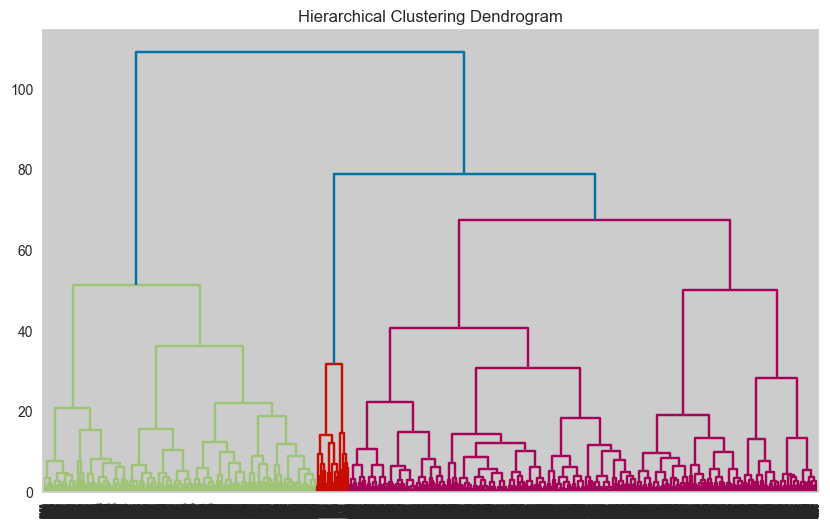

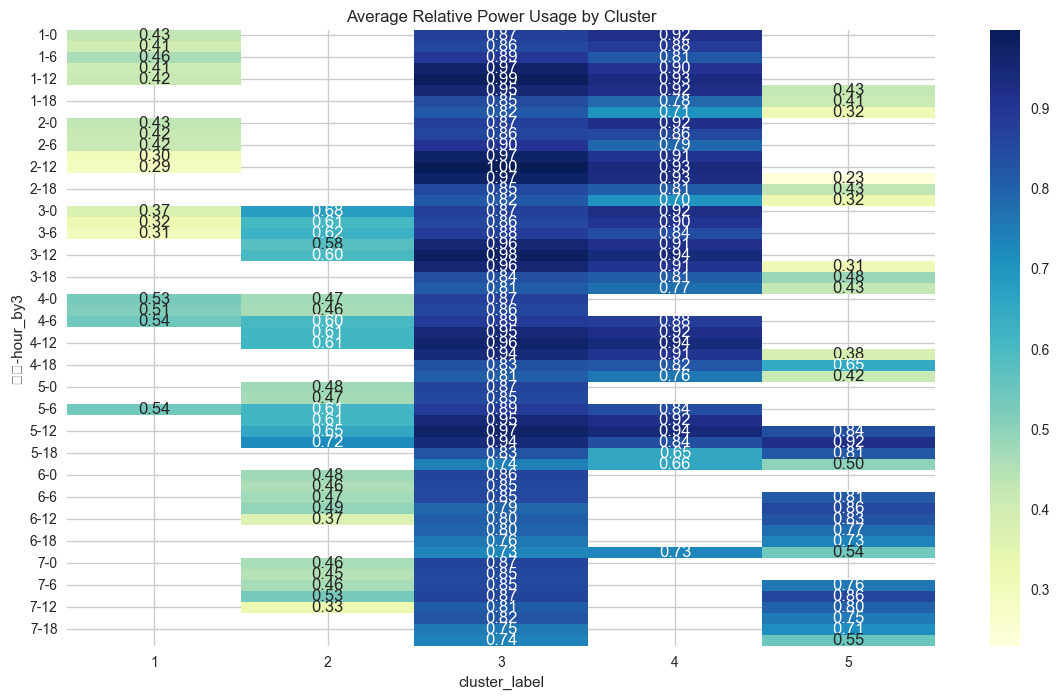

In [289]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler
# '일시' 열을 문자열로 변환
train_df['일시'] = train_df['일시'].astype(str)
# 1. 'hour_by3' 특성 생성
train_df['hour_by3'] = (train_df['일시'].str.split(" ").str[1].str[:2].astype(int) // 3) * 3

# 2. 전력 사용량의 중앙값 및 정규화된 전력 사용량 계산
agg_cl = train_df.groupby(['건물번호', 'hour_by3', '요일'])['전력소비량(kWh)'].median().reset_index()
agg_cl['R'] = agg_cl.groupby('건물번호')['전력소비량(kWh)'].transform(lambda x: x / x.max())

# Standardize data before clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(agg_cl.drop('건물번호', axis=1))

# 3. 계층적 군집화
Z = linkage(scaled_data, method='ward')

# Determine clusters using a cut-off
num_clusters = 5
labels = fcluster(Z, t=num_clusters, criterion='maxclust')

# Add cluster labels to dataframe
agg_cl['cluster_label'] = labels

# 4. Visualize the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z)
plt.axhline(y=150, color='r', linestyle='--')  # You might need to adjust the value 150 based on the dendrogram
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

# 5. 각 군집에 대한 평균 계산
mean_values = agg_cl.groupby(['cluster_label', 'hour_by3', '요일'])['R'].mean().reset_index()
mean_values.rename(columns={'R': 'MM'}, inplace=True)

# Visualize the mean values for each cluster
plt.figure(figsize=(14, 8))
sns.heatmap(mean_values.pivot_table(index=['요일', 'hour_by3'], columns='cluster_label', values='MM'),
            cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Average Relative Power Usage by Cluster")
plt.show()


### 휴일 안 빼고 건물 번호로 클러스터링 
점수 :  6.6297094495    
### 위에서 blend하기  
점수 :    
### 휴일 빼고 건물 번호로 클러스터링
점수 :  
### 위에서 blend하기 
점수 :   6.3348572794   
점수 :   6.4377835712(clustering 12개)   
   
### 휴일 안 빼고 건물 유형으로 클러스터링
점수 :   
### 위에서 blend하기  
점수 :   
### 휴일 빼고 건물 유형으로 클러스터링
점수 :  6.5382354746   
### 위에서 blend하기 
점수 :  6.2134266691   

## 건물 번호로 클러스터링

In [161]:
from sklearn.metrics import make_scorer
from pycaret.regression import *
from pycaret.clustering import setup as setup_clustering, create_model as create_clustering_model, predict_model as predict_clustering_model

def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

# 건물번호에 따라 클러스터링
clustering_setup = setup_clustering(data=train_df, categorical_features=['건물번호'], ignore_features=['전력소비량(kWh)'])
kmeans = create_clustering_model('kmeans', num_clusters=5)

train_df['Cluster'] = predict_clustering_model(kmeans, data=train_df)['Cluster']
train_df['Cluster'] = train_df['Cluster'].str.extract('(\d+)').astype(int)  # Cluster 문자열에서 숫자만 추출

# test 데이터에 대해서도 동일한 변환을 수행
test_df['Cluster'] = predict_clustering_model(kmeans, data=test_df)['Cluster']
test_df['Cluster'] = test_df['Cluster'].str.extract('(\d+)').astype(int)

# 클러스터링된 각 그룹에 대해 pycaret을 이용해 모델 학습
models = []
for cluster in train_df['Cluster'].unique():
    print(f"Training model for cluster {cluster}")
    data = train_df[train_df['Cluster'] == cluster]
    
    setup_reg = setup(data, target='전력소비량(kWh)')
    
    # SMAPE 메트릭 추가
    add_metric('smape', 'SMAPE', smape, greater_is_better=False)
    
    best_model = compare_models(sort='SMAPE', n_select=1)
    models.append(best_model)

# test.csv를 학습된 모델에 넣어 예측
test_df['전력소비량(kWh)'] = 0

for cluster, model in zip(train_df['Cluster'].unique(), models):
    idx = test_df[test_df['Cluster'] == cluster].index
    predictions = predict_model(model, data=test_df.loc[idx])
    test_df.loc[idx, '전력소비량(kWh)'] = predictions['prediction_label']

# sample_submission 형식에 맞게 예측값 저장
submission = pd.read_csv('./sample_submission.csv')
submission['answer'] = test_df['전력소비량(kWh)']
submission.to_csv('./sample_submission.csv', index=False)


### blend까지 시키기

In [43]:
from sklearn.metrics import make_scorer
from pycaret.regression import *
from pycaret.clustering import setup as setup_clustering, create_model as create_clustering_model, predict_model as predict_clustering_model

def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

# 건물번호에 따라 클러스터링
clustering_setup = setup_clustering(data=train_df, categorical_features=['건물번호'], ignore_features=['전력소비량(kWh)'])
kmeans = create_clustering_model('kmeans', num_clusters=12)

train_df['Cluster'] = predict_clustering_model(kmeans, data=train_df)['Cluster']
train_df['Cluster'] = train_df['Cluster'].str.extract('(\d+)').astype(int)  # Cluster 문자열에서 숫자만 추출

# test 데이터에 대해서도 동일한 변환을 수행
test_df['Cluster'] = predict_clustering_model(kmeans, data=test_df)['Cluster']
test_df['Cluster'] = test_df['Cluster'].str.extract('(\d+)').astype(int)

# 클러스터링된 각 그룹에 대해 pycaret을 이용해 모델 학습
blended_models = []  # 여기에 각 클러스터마다의 blended model을 저장합니다.
for cluster in train_df['Cluster'].unique():
    print(f"Training model for cluster {cluster}")
    data = train_df[train_df['Cluster'] == cluster]
    
    setup_reg = setup(data, target='전력소비량(kWh)')
    
    # SMAPE 메트릭 추가
    add_metric('smape', 'SMAPE', smape, greater_is_better=False)
    
    top2_models = compare_models(sort='SMAPE', n_select=2, fold=10)
    blended = blend_models(estimator_list=top2_models, fold=10, optimize='SMAPE')
    blended_models.append(blended)

# test.csv를 학습된 모델에 넣어 예측
test_df['전력소비량(kWh)'] = 0

for cluster, model in zip(train_df['Cluster'].unique(), blended_models):
    idx = test_df[test_df['Cluster'] == cluster].index
    predictions = predict_model(model, data=test_df.loc[idx])
    test_df.loc[idx, '전력소비량(kWh)'] = predictions['prediction_label']


# sample_submission 형식에 맞게 예측값 저장
submission = pd.read_csv('./sample_submission.csv')
submission['answer'] = test_df['전력소비량(kWh)']
submission.to_csv('./sample_submission.csv', index=False)


,Description,Value
0,Session id,1974
1,Original data shape,"(199200, 21)"
2,Transformed data shape,"(199200, 119)"
3,Ignore features,1
4,Numeric features,19
5,Categorical features,1
6,Preprocess,True
7,Imputation type,simple
8,Numeric imputation,mean
9,Categorical imputation,mode


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5092,92897371.4057,0.5015,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Training model for cluster 5


,Description,Value
0,Session id,559
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(47808, 22)"
4,Transformed data shape,"(47808, 22)"
5,Transformed train set shape,"(33465, 22)"
6,Transformed test set shape,"(14343, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,73.6587,16795.2071,129.4574,0.9882,0.0767,0.0427,4.0813,5.3370
rf,Random Forest Regressor,80.4459,19906.1293,140.8823,0.9860,0.0798,0.0454,4.3431,9.7810
dt,Decision Tree Regressor,104.0841,40929.7243,202.1265,0.9711,0.1090,0.0568,5.5095,0.7970
catboost,CatBoost Regressor,106.6830,25671.6749,160.0746,0.9819,0.1136,0.0693,6.6487,5.0400
xgboost,Extreme Gradient Boosting,119.1990,31242.3152,176.6914,0.9780,0.1281,0.0766,7.3998,2.1850
lightgbm,Light Gradient Boosting Machine,134.3538,37747.3877,194.2014,0.9734,0.1360,0.0869,8.2006,1.1740
gbr,Gradient Boosting Regressor,294.1107,151357.1187,388.9336,0.8933,0.2811,0.2081,18.2998,2.7500
knn,K Neighbors Regressor,545.5044,592087.0312,769.4009,0.5826,0.4478,0.3760,29.4446,0.8900
ada,AdaBoost Regressor,637.4056,540073.4206,734.7919,0.6193,0.5007,0.5239,36.3715,1.7550
llar,Lasso Least Angle Regression,654.1862,654614.6000,808.9844,0.5386,0.5392,0.4811,37.3434,0.8440


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,77.5138,18132.2071,134.6559,0.9872,0.0776,0.0439,4.2117
1,72.2875,13860.3170,117.7298,0.9902,0.0670,0.0402,3.9240
2,72.2568,16870.5826,129.8868,0.9879,0.0732,0.0414,3.9989
3,76.6787,20337.0939,142.6082,0.9857,0.0841,0.0449,4.2409
4,74.4826,15939.6202,126.2522,0.9892,0.0828,0.0444,4.1271
5,74.2268,15810.6221,125.7403,0.9886,0.0698,0.0410,4.0047
6,75.1187,18318.7493,135.3468,0.9871,0.0780,0.0433,4.1030
7,73.1056,15740.0928,125.4595,0.9887,0.0755,0.0423,4.0565
8,72.8404,16812.2296,129.6620,0.9884,0.0784,0.0426,4.0228


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Training model for cluster 10


,Description,Value
0,Session id,4656
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(15936, 22)"
4,Transformed data shape,"(15936, 22)"
5,Transformed train set shape,"(11155, 22)"
6,Transformed test set shape,"(4781, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,101.5460,31736.0995,177.6410,0.9887,0.0979,0.0573,5.4855,1.8170
rf,Random Forest Regressor,109.6328,35832.1797,188.7322,0.9872,0.1010,0.0609,5.8645,3.1820
catboost,CatBoost Regressor,120.7342,33364.2497,182.3427,0.9881,0.1083,0.0694,6.7088,2.8770
dt,Decision Tree Regressor,138.8600,69718.7536,263.4332,0.9752,0.1362,0.0751,7.2813,0.7140
xgboost,Extreme Gradient Boosting,135.2266,40837.4410,201.5945,0.9855,0.1172,0.0769,7.4413,1.2800
lightgbm,Light Gradient Boosting Machine,140.5398,44095.7788,209.7500,0.9843,0.1249,0.0832,7.8901,0.9080
gbr,Gradient Boosting Regressor,308.8466,171629.2873,414.1585,0.9391,0.2297,0.1737,16.0610,1.3440
knn,K Neighbors Regressor,717.0841,982538.3625,990.7213,0.6523,0.4089,0.3569,30.2548,0.7680
ada,AdaBoost Regressor,668.5977,582240.9441,762.7212,0.7937,0.4346,0.4489,34.0726,1.0620
llar,Lasso Least Angle Regression,645.0508,683665.6688,826.5801,0.7580,0.5615,0.3849,35.1675,0.8190


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,99.1536,29473.3837,171.6781,0.9902,0.0998,0.0576,5.4338
1,101.6272,29729.3618,172.4220,0.9898,0.0913,0.0544,5.3198
2,107.0596,35458.0897,188.3032,0.9873,0.0910,0.0587,5.6715
3,99.5428,29415.8797,171.5106,0.9896,0.0921,0.0552,5.3322
4,100.5817,29039.7140,170.4104,0.9905,0.0955,0.0557,5.3491
5,105.9881,40295.5981,200.7376,0.9837,0.1003,0.0592,5.6826
6,103.2213,34414.8170,185.5123,0.9879,0.0993,0.0577,5.5161
7,103.9850,27691.3988,166.4073,0.9895,0.0986,0.0594,5.7154
8,93.2919,22606.7394,150.3554,0.9921,0.0973,0.0562,5.3146


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Training model for cluster 3


,Description,Value
0,Session id,4162
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(49800, 22)"
4,Transformed data shape,"(49800, 22)"
5,Transformed train set shape,"(34860, 22)"
6,Transformed test set shape,"(14940, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,63.0260,15034.3012,122.4362,0.9742,0.1025,0.0548,5.0544,4.9050
rf,Random Forest Regressor,66.7209,16426.4720,127.9760,0.9718,0.1014,0.0562,5.2422,9.8880
dt,Decision Tree Regressor,84.8984,29990.5596,172.7593,0.9484,0.1336,0.0697,6.6330,0.8900
catboost,CatBoost Regressor,84.0855,17854.9543,133.5158,0.9694,0.1270,0.0758,7.2550,4.8660
xgboost,Extreme Gradient Boosting,92.1193,20804.6586,144.0958,0.9643,0.1393,0.0828,7.9302,2.1670
lightgbm,Light Gradient Boosting Machine,101.2097,24038.8045,154.9815,0.9587,0.1306,0.0895,8.4014,1.0890
gbr,Gradient Boosting Regressor,216.6668,94800.4031,307.8404,0.8373,0.2513,0.2017,17.5322,2.9370
knn,K Neighbors Regressor,365.1700,272954.2734,522.3265,0.5315,0.4023,0.3371,27.7100,0.9700
ada,AdaBoost Regressor,393.6222,233027.0870,482.6894,0.5998,0.4305,0.4257,31.7641,1.5690
lasso,Lasso Regression,416.9581,284816.5125,533.6183,0.5112,0.4585,0.3884,33.3455,1.0800


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,62.7982,14440.5996,120.1690,0.9744,0.0980,0.0530,4.9291
1,63.4816,14708.6280,121.2791,0.9744,0.1048,0.0566,5.1757
2,61.9597,12943.4073,113.7691,0.9776,0.0894,0.0513,4.9032
3,63.9940,15124.1105,122.9801,0.9741,0.1035,0.0562,5.1421
4,60.8972,15248.8913,123.4864,0.9733,0.0969,0.0519,4.8249
5,62.6011,12052.0054,109.7816,0.9798,0.0932,0.0518,4.9149
6,62.6186,15766.8761,125.5662,0.9739,0.0987,0.0527,4.9249
7,64.8099,18115.6533,134.5944,0.9703,0.1092,0.0573,5.1506
8,62.8241,13505.0690,116.2113,0.9768,0.0980,0.0535,5.0487


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Training model for cluster 4


,Description,Value
0,Session id,3807
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(15936, 22)"
4,Transformed data shape,"(15936, 22)"
5,Transformed train set shape,"(11155, 22)"
6,Transformed test set shape,"(4781, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,87.7774,24734.5015,156.9909,0.9927,0.0581,0.0380,3.7404,1.8410
rf,Random Forest Regressor,99.2471,34528.0326,185.0214,0.9897,0.0661,0.0427,4.1999,3.2350
dt,Decision Tree Regressor,122.1269,53808.4944,231.5299,0.9840,0.0859,0.0532,5.2568,0.8320
catboost,CatBoost Regressor,122.6298,48316.0617,218.8339,0.9857,0.0812,0.0536,5.2729,2.9710
xgboost,Extreme Gradient Boosting,139.2206,61966.3652,247.6644,0.9817,0.0903,0.0612,5.9828,1.3400
lightgbm,Light Gradient Boosting Machine,133.1343,46361.1532,214.6175,0.9863,0.0873,0.0635,6.2062,0.9920
gbr,Gradient Boosting Regressor,347.3636,290826.2544,538.3777,0.9137,0.1991,0.1551,14.7314,1.4740
knn,K Neighbors Regressor,602.4257,918974.3812,958.2878,0.7273,0.3002,0.2382,22.1510,0.8350
ada,AdaBoost Regressor,656.2244,878015.7413,936.4044,0.7398,0.3259,0.2992,25.0104,0.8960
ridge,Ridge Regression,666.0857,793990.5812,890.7205,0.7644,0.4812,0.3357,33.2048,0.7850


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,86.9297,20527.5392,143.2743,0.9945,0.0551,0.0380,3.7610
1,95.6331,31156.5932,176.5123,0.9906,0.0646,0.0413,4.0764
2,86.7602,27117.4359,164.6737,0.9921,0.0610,0.0385,3.7591
3,95.6475,29160.9773,170.7659,0.9909,0.0623,0.0413,4.0708
4,94.0781,31524.2931,177.5508,0.9912,0.0581,0.0375,3.6694
5,89.8624,29188.3935,170.8461,0.9910,0.0627,0.0399,3.9225
6,90.1026,24955.2055,157.9722,0.9926,0.0596,0.0395,3.9311
7,93.0996,26694.1160,163.3833,0.9923,0.0591,0.0398,3.9455
8,88.6495,31057.9228,176.2326,0.9907,0.0621,0.0376,3.6383


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Training model for cluster 9


,Description,Value
0,Session id,2436
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(17928, 22)"
4,Transformed data shape,"(17928, 22)"
5,Transformed train set shape,"(12549, 22)"
6,Transformed test set shape,"(5379, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,76.8451,14711.8097,121.0116,0.9883,0.0988,0.2196,4.5592,2.1170
rf,Random Forest Regressor,81.0703,15837.7104,125.5925,0.9874,0.1016,0.3105,4.7848,3.6190
catboost,CatBoost Regressor,84.2163,15072.7265,122.5831,0.9880,0.0981,0.2270,4.9658,3.0670
xgboost,Extreme Gradient Boosting,96.4231,19230.6570,138.5084,0.9847,0.1057,0.2256,5.6556,1.5410
lightgbm,Light Gradient Boosting Machine,98.7097,19691.1265,140.1641,0.9843,0.1073,0.3210,5.7599,1.0280
dt,Decision Tree Regressor,108.0430,30496.7598,174.3196,0.9757,0.1347,0.3957,6.3575,0.8570
gbr,Gradient Boosting Regressor,215.4697,90030.3102,299.8521,0.9284,0.1779,0.4414,12.0288,1.7770
ada,AdaBoost Regressor,452.9988,282047.9985,530.8449,0.7758,0.3216,0.5812,25.2135,1.1600
knn,K Neighbors Regressor,535.7640,578484.2688,760.3523,0.5402,0.3666,0.4968,26.4779,0.8830
lr,Linear Regression,486.8545,390433.7281,624.7497,0.6896,0.4984,0.6912,29.7269,0.8040


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,73.2113,13201.1544,114.8963,0.9893,0.1983,2.2229,4.4898
1,82.2981,16176.1392,127.1855,0.9869,0.2127,0.0487,5.0135
2,78.1340,14653.8745,121.0532,0.9880,0.0787,0.0501,4.8401
3,83.8018,19110.5359,138.2409,0.9851,0.0733,0.0477,4.6955
4,77.7799,15272.4526,123.5818,0.9873,0.0735,0.0470,4.5990
5,71.2450,11566.0832,107.5457,0.9918,0.0646,0.0419,4.1597
6,75.2382,13154.3449,114.6924,0.9892,0.0713,0.0454,4.4629
7,77.5647,15216.3407,123.3545,0.9880,0.0735,0.0462,4.5701
8,74.6609,12933.0412,113.7235,0.9895,0.0705,0.0447,4.3682


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Training model for cluster 0


,Description,Value
0,Session id,1829
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(5976, 22)"
4,Transformed data shape,"(5976, 22)"
5,Transformed train set shape,"(4183, 22)"
6,Transformed test set shape,"(1793, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,66.0348,11999.7013,108.5749,0.9943,0.0711,0.0459,4.5077,1.3240
catboost,CatBoost Regressor,65.8979,9513.7533,96.9539,0.9955,0.0734,0.0494,4.8943,2.2680
rf,Random Forest Regressor,75.3049,14458.5006,119.6095,0.9931,0.0799,0.0533,5.2449,1.8430
xgboost,Extreme Gradient Boosting,78.0197,14285.0858,118.9694,0.9932,0.0837,0.0565,5.5970,1.2470
lightgbm,Light Gradient Boosting Machine,75.2385,13182.5185,114.4583,0.9937,0.0855,0.0573,5.6669,1.0900
dt,Decision Tree Regressor,100.5479,29076.5036,169.4913,0.9861,0.1130,0.0701,6.9105,0.9300
gbr,Gradient Boosting Regressor,221.6818,96876.7443,310.3005,0.9538,0.1997,0.1461,14.4178,1.3030
ada,AdaBoost Regressor,368.8247,204040.6089,451.3114,0.9021,0.3141,0.3044,24.9258,1.0630
knn,K Neighbors Regressor,633.7562,1019477.0000,1008.9779,0.5105,0.4206,0.3680,31.5513,0.9410
huber,Huber Regressor,765.6044,1613440.9451,1265.1275,0.2325,0.5858,0.4615,42.1376,0.8940


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,64.5805,10532.8977,102.6299,0.9950,0.0734,0.0465,4.5203
1,62.4528,12825.0139,113.2476,0.9943,0.0696,0.0449,4.3259
2,56.1402,7392.1869,85.9778,0.9964,0.0631,0.0411,4.0840
3,62.5030,10082.0980,100.4097,0.9957,0.0593,0.0407,4.0143
4,60.5646,9436.7821,97.1431,0.9957,0.0608,0.0402,4.0021
5,52.8744,5882.7862,76.6993,0.9966,0.0681,0.0428,4.2255
6,54.3448,7169.1081,84.6706,0.9965,0.0626,0.0426,4.1565
7,56.1652,7122.7013,84.3961,0.9966,0.0637,0.0419,4.2246
8,68.1329,11524.1278,107.3505,0.9950,0.0707,0.0449,4.4493


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Training model for cluster 6


,Description,Value
0,Session id,1574
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(31872, 22)"
4,Transformed data shape,"(31872, 22)"
5,Transformed train set shape,"(22310, 22)"
6,Transformed test set shape,"(9562, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,50.1230,10026.2016,99.8829,0.9984,0.0508,0.0243,2.3857,3.1220
rf,Random Forest Regressor,53.3914,10555.8059,102.5587,0.9983,0.0515,0.0257,2.5263,5.9700
catboost,CatBoost Regressor,58.4448,10528.8547,102.4109,0.9983,0.0540,0.0294,2.8921,4.0360
xgboost,Extreme Gradient Boosting,60.6583,11431.6775,106.6894,0.9982,0.0550,0.0301,2.9630,1.8490
lightgbm,Light Gradient Boosting Machine,67.8158,13181.2933,114.6860,0.9979,0.0595,0.0339,3.3222,1.2060
dt,Decision Tree Regressor,70.9863,20605.2111,143.3001,0.9968,0.0712,0.0337,3.3351,1.0940
gbr,Gradient Boosting Regressor,112.6750,29881.1542,172.8164,0.9953,0.0947,0.0594,5.6990,2.1850
knn,K Neighbors Regressor,146.3664,52132.9555,228.3024,0.9918,0.1290,0.0801,7.7233,1.1320
ada,AdaBoost Regressor,262.6601,112254.3667,334.8161,0.9824,0.1770,0.1391,12.6958,1.4740
huber,Huber Regressor,1321.8035,4842966.9825,2199.9594,0.2408,0.5569,0.4835,38.8345,1.2090


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,51.6021,9989.1176,99.9456,0.9984,0.0509,0.0247,2.4190
1,49.2527,9103.4108,95.4118,0.9987,0.0480,0.0236,2.3170
2,54.7446,12552.1149,112.0362,0.9980,0.0529,0.0260,2.5557
3,48.7611,8297.9996,91.0934,0.9987,0.0459,0.0237,2.3212
4,49.2109,8816.0273,93.8937,0.9987,0.0498,0.0247,2.4115
5,48.6535,8802.8522,93.8235,0.9986,0.0476,0.0236,2.3318
6,53.2723,12200.1001,110.4541,0.9982,0.0580,0.0262,2.5632
7,49.3313,9498.4775,97.4601,0.9986,0.0497,0.0238,2.3350
8,51.7790,9791.1994,98.9505,0.9984,0.0491,0.0246,2.4303


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Training model for cluster 1


,Description,Value
0,Session id,7062
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(1992, 22)"
4,Transformed data shape,"(1992, 22)"
5,Transformed train set shape,"(1394, 22)"
6,Transformed test set shape,"(598, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,62.2259,13065.2393,113.1787,0.9858,0.0674,0.0378,3.6505,1.1810
rf,Random Forest Regressor,67.5276,14274.1889,118.1031,0.9846,0.0670,0.0395,3.8656,1.3220
catboost,CatBoost Regressor,68.1752,13072.4635,113.1428,0.9859,0.0672,0.0421,4.0877,1.9330
xgboost,Extreme Gradient Boosting,69.2742,14174.6207,118.4692,0.9848,0.0710,0.0425,4.1460,1.1560
lightgbm,Light Gradient Boosting Machine,77.3819,19007.5722,134.7132,0.9793,0.0853,0.0493,4.7709,1.1220
dt,Decision Tree Regressor,88.9546,24439.2663,155.1058,0.9739,0.0821,0.0494,4.9191,0.9720
gbr,Gradient Boosting Regressor,81.9409,17881.4012,132.4908,0.9806,0.0837,0.0522,5.0799,1.1730
ada,AdaBoost Regressor,186.4064,59315.8804,242.7928,0.9361,0.1486,0.1227,11.4399,1.0930
en,Elastic Net,584.8036,472327.2812,687.0043,0.4942,0.4065,0.4033,34.0558,1.0100
br,Bayesian Ridge,510.7924,378160.8500,614.4695,0.5939,0.4950,0.3966,35.0837,0.9560


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,49.4545,5576.0422,74.6729,0.9944,0.0377,0.0281,2.8082
1,69.4825,16717.6514,129.2968,0.9834,0.0733,0.0409,3.9254
2,62.9756,13580.9045,116.5371,0.9853,0.0686,0.0376,3.6881
3,67.8358,12580.9522,112.1648,0.9871,0.0615,0.0381,3.7164
4,63.5104,13340.8990,115.5028,0.9850,0.0878,0.0453,4.1334
5,62.9580,10921.4102,104.5056,0.9888,0.0594,0.0353,3.5143
6,59.2530,10620.4103,103.0554,0.9889,0.0587,0.0350,3.3780
7,68.4627,16924.6514,130.0948,0.9829,0.0711,0.0389,3.9848
8,67.2923,17304.6515,131.5471,0.9768,0.0841,0.0453,4.2227


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Training model for cluster 2


,Description,Value
0,Session id,670
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(5976, 22)"
4,Transformed data shape,"(5976, 22)"
5,Transformed train set shape,"(4183, 22)"
6,Transformed test set shape,"(1793, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
catboost,CatBoost Regressor,176.0665,65614.5594,255.5195,0.9984,0.0385,0.0239,2.3360,2.2950
et,Extra Trees Regressor,195.7819,84545.8379,289.3168,0.9979,0.0408,0.0256,2.4987,1.4010
xgboost,Extreme Gradient Boosting,216.3265,96722.7375,309.8454,0.9976,0.0439,0.0288,2.8364,1.4430
rf,Random Forest Regressor,230.6644,113883.1121,335.9076,0.9972,0.0450,0.0293,2.8661,1.8610
lightgbm,Light Gradient Boosting Machine,212.3643,97196.5459,310.7023,0.9976,0.0480,0.0293,2.8751,1.2490
dt,Decision Tree Regressor,309.0335,218446.5392,466.2767,0.9947,0.0606,0.0389,3.8035,1.0050
gbr,Gradient Boosting Regressor,508.3409,448090.9878,668.9715,0.9891,0.1284,0.0741,7.3240,1.3270
ada,AdaBoost Regressor,1142.4420,2009234.7280,1416.7617,0.9510,0.1790,0.1497,13.8063,1.2100
knn,K Neighbors Regressor,1609.1734,4862072.9000,2204.0461,0.8815,0.2169,0.1786,17.1848,1.0130
omp,Orthogonal Matching Pursuit,1995.3795,6903073.2000,2625.3167,0.8317,0.2621,0.2257,21.2946,1.0040


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,176.2391,88775.7663,297.9526,0.9977,0.0760,0.0309,2.6379
1,162.1818,52170.8475,228.4094,0.9988,0.0283,0.0201,2.0131
2,169.3652,59422.7214,243.7678,0.9986,0.0314,0.0225,2.2417
3,169.8738,67064.0186,258.9672,0.9985,0.0303,0.0219,2.1915
4,159.4250,56546.7497,237.7956,0.9985,0.0327,0.0212,2.1115
5,161.1837,53714.5762,231.7641,0.9987,0.0276,0.0201,2.0125
6,179.6418,74089.2554,272.1934,0.9981,0.0327,0.0208,2.0765
7,160.9834,51930.7515,227.8832,0.9987,0.0387,0.0222,2.1659
8,157.9723,46911.4768,216.5906,0.9989,0.0293,0.0197,1.9672


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Training model for cluster 8


,Description,Value
0,Session id,638
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(1992, 22)"
4,Transformed data shape,"(1992, 22)"
5,Transformed train set shape,"(1394, 22)"
6,Transformed test set shape,"(598, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
catboost,CatBoost Regressor,146.6462,50853.8933,220.3281,0.9910,0.0294,0.0199,1.9660,2.1120
et,Extra Trees Regressor,158.9747,59792.2741,236.6930,0.9893,0.0311,0.0213,2.1058,1.3030
xgboost,Extreme Gradient Boosting,161.0774,58796.3594,238.9239,0.9895,0.0312,0.0215,2.1359,1.2860
lightgbm,Light Gradient Boosting Machine,162.7625,64732.1444,251.2055,0.9885,0.0340,0.0221,2.1836,1.2120
rf,Random Forest Regressor,175.9131,68447.4573,257.4568,0.9878,0.0331,0.0231,2.2945,1.4680
gbr,Gradient Boosting Regressor,192.8664,77703.7644,273.6392,0.9862,0.0363,0.0259,2.5703,1.2190
dt,Decision Tree Regressor,232.6654,119974.6610,343.3731,0.9788,0.0439,0.0308,3.0511,1.2970
ada,AdaBoost Regressor,446.3298,296647.4178,542.8721,0.9481,0.0746,0.0635,6.2175,1.1350
lr,Linear Regression,950.8407,1419355.5500,1190.2961,0.7499,0.1741,0.1421,13.7071,1.1040
ridge,Ridge Regression,951.2709,1418870.5500,1190.0886,0.7500,0.1740,0.1421,13.7079,1.0250


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,123.3166,30522.9655,174.7082,0.9941,0.0220,0.0165,1.6497
1,116.9354,35502.6022,188.4213,0.9939,0.0247,0.0158,1.5663
2,133.6481,31628.8216,177.8449,0.9948,0.0221,0.0172,1.7074
3,158.7361,56246.2627,237.1629,0.9906,0.0284,0.0204,2.0433
4,135.3717,37235.1063,192.9640,0.9937,0.0236,0.0175,1.7500
5,181.5152,138340.4474,371.9415,0.9733,0.0566,0.0269,2.5231
6,148.6155,36254.1658,190.4053,0.9945,0.0238,0.0187,1.8706
7,132.7695,32244.6349,179.5679,0.9938,0.0232,0.0177,1.7744
8,138.5996,40851.3504,202.1172,0.9921,0.0282,0.0197,1.9506


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Training model for cluster 7


,Description,Value
0,Session id,1685
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(1992, 22)"
4,Transformed data shape,"(1992, 22)"
5,Transformed train set shape,"(1394, 22)"
6,Transformed test set shape,"(598, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
catboost,CatBoost Regressor,69.6347,9945.3532,98.4960,0.9892,0.0279,0.0198,1.9730,2.1340
lightgbm,Light Gradient Boosting Machine,77.4584,13073.7250,113.3330,0.9857,0.0327,0.0222,2.1977,1.2520
xgboost,Extreme Gradient Boosting,84.0072,13917.4441,117.1869,0.9848,0.0327,0.0238,2.3706,1.2900
et,Extra Trees Regressor,85.4376,16354.9445,125.3177,0.9822,0.0361,0.0247,2.4368,1.3670
rf,Random Forest Regressor,97.4102,19976.8502,139.7751,0.9782,0.0389,0.0276,2.7398,1.4930
gbr,Gradient Boosting Regressor,109.2732,24130.4865,153.9977,0.9738,0.0441,0.0312,3.1104,1.2480
dt,Decision Tree Regressor,128.6162,38007.8609,193.2762,0.9588,0.0533,0.0360,3.5948,1.1700
ada,AdaBoost Regressor,232.7541,85427.5011,291.6391,0.9071,0.0815,0.0678,6.6200,1.2060
br,Bayesian Ridge,438.4766,299548.6828,546.4917,0.6730,0.1538,0.1277,12.4408,1.1400
llar,Lasso Least Angle Regression,438.4974,299549.1469,546.4870,0.6731,0.1539,0.1278,12.4478,1.1330


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,62.1027,7425.7432,86.1728,0.9929,0.0269,0.0179,1.7754
1,74.0507,11386.1574,106.7059,0.9899,0.0286,0.0206,2.0603
2,65.0764,7320.1320,85.5578,0.9915,0.0241,0.0187,1.8616
3,66.9107,8105.3711,90.0298,0.9899,0.0249,0.0191,1.9069
4,77.6565,12673.4014,112.5762,0.9852,0.0310,0.0218,2.1752
5,61.8614,8010.2459,89.5000,0.9925,0.0225,0.0165,1.6504
6,62.8817,8049.2547,89.7176,0.9912,0.0234,0.0171,1.7106
7,79.0122,15615.4866,124.9619,0.9828,0.0374,0.0228,2.2229
8,74.6704,15485.9439,124.4425,0.9830,0.0415,0.0230,2.2413


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Training model for cluster 11


,Description,Value
0,Session id,3732
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(1992, 22)"
4,Transformed data shape,"(1992, 22)"
5,Transformed train set shape,"(1394, 22)"
6,Transformed test set shape,"(598, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
catboost,CatBoost Regressor,49.3660,4876.3715,69.4113,0.9853,0.0305,0.0235,2.3495,2.2080
lightgbm,Light Gradient Boosting Machine,65.8702,8210.7414,90.3915,0.9754,0.0411,0.0319,3.1760,1.2850
xgboost,Extreme Gradient Boosting,72.1917,9765.3294,98.5943,0.9705,0.0451,0.0350,3.4957,1.3000
et,Extra Trees Regressor,78.7503,13462.9560,114.8948,0.9600,0.0490,0.0371,3.7027,1.3570
rf,Random Forest Regressor,90.5527,17096.1560,130.3033,0.9488,0.0568,0.0428,4.2559,1.4740
gbr,Gradient Boosting Regressor,97.4295,16476.2385,127.9973,0.9503,0.0605,0.0486,4.8284,1.2850
dt,Decision Tree Regressor,122.2753,34582.3721,184.6708,0.8967,0.0788,0.0567,5.6684,1.1330
ada,AdaBoost Regressor,188.6733,50376.7475,224.1412,0.8483,0.1211,0.1046,9.9369,1.2360
lasso,Lasso Regression,285.9273,123234.2758,350.6707,0.6293,0.1817,0.1494,14.7244,1.1370
br,Bayesian Ridge,285.8578,123105.2352,350.4963,0.6296,0.1817,0.1495,14.7277,1.1700


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,50.4283,4869.9089,69.7847,0.9817,0.0318,0.0242,2.4096
1,58.9865,6796.5659,82.4413,0.9806,0.0365,0.0281,2.8101
2,47.1404,4400.7472,66.3381,0.9872,0.0324,0.0241,2.3950
3,56.7536,6828.4981,82.6347,0.9841,0.0337,0.0264,2.6387
4,57.7125,5972.1643,77.2798,0.9846,0.0351,0.0273,2.7283
5,55.8726,5432.5282,73.7057,0.9806,0.0341,0.0273,2.7170
6,55.2552,6572.5041,81.0710,0.9803,0.0348,0.0263,2.6243
7,52.3627,5042.6638,71.0117,0.9854,0.0331,0.0257,2.5470
8,50.2235,4982.9052,70.5897,0.9846,0.0315,0.0240,2.4070


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Voting Regressor,2083.5763,5501698.1202,2345.5699,0.0000,7.4986,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Voting Regressor,2417.1410,8393761.3616,2897.1989,0.0000,7.6077,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Voting Regressor,1339.4594,2254849.3201,1501.6156,0.0000,7.0825,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Voting Regressor,2425.1423,9003685.5745,3000.6142,0.0000,7.5654,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Voting Regressor,1899.4461,4749748.0701,2179.3917,0.0000,7.4315,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Voting Regressor,1818.1837,5121646.1450,2263.1054,0.0000,7.2700,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Voting Regressor,3084.7451,15609072.2536,3950.8318,0.0000,7.8160,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Voting Regressor,1695.5548,3745953.9043,1935.4467,0.0000,7.3126,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Voting Regressor,9736.8277,129746680.0884,11390.6400,0.0000,8.9701,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Voting Regressor,7153.3266,56005914.8237,7483.7100,0.0000,8.8355,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Voting Regressor,3374.6547,11942128.7672,3455.7385,0.0000,8.1045,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Voting Regressor,1949.5045,3973248.6993,1993.3010,0.0000,7.5555,nan,200.0000


## 건물 유형 별로 학습 시키고, 건물 번호로 5개 클러스터링 해서 학습시킨 후 예측 -> 평균을 내거나, blending해보자 두 결과를

In [25]:
from sklearn.metrics import make_scorer
from pycaret.regression import *

def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

# "건물유형"의 고유한 값들을 구합니다.
unique_building_types = train_df['건물유형'].unique()

# 각 "건물유형"에 대한 모델을 저장할 리스트
models = []

for building_type in unique_building_types:
    print(f"Training model for building type: {building_type}")
    
    # 해당 건물 유형의 데이터만 선택
    data = train_df[train_df['건물유형'] == building_type]
    
    # PyCaret 설정
    setup_reg = setup(data, target='전력소비량(kWh)' ,session_id=seed )
    
    # SMAPE 메트릭 추가
    add_metric('smape', 'SMAPE', smape, greater_is_better=False)
    
    # 모델 학습
    best_model = compare_models(sort='SMAPE', n_select=1)
    models.append(best_model)

# test.csv에 대한 예측
test_df['전력소비량(kWh)'] = 0

for building_type, model in zip(unique_building_types, models):
    idx = test_df[test_df['건물유형'] == building_type].index
    predictions = predict_model(model, data=test_df.loc[idx])
    test_df.loc[idx, '전력소비량(kWh)'] = predictions['prediction_label']

# sample_submission 형식에 맞게 예측값 저장
from sklearn.metrics import make_scorer
from pycaret.regression import *
from pycaret.clustering import setup as setup_clustering, create_model as create_clustering_model, predict_model as predict_clustering_model

def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

# 건물번호에 따라 클러스터링
clustering_setup = setup_clustering(data=train_df, categorical_features=['건물번호'], ignore_features=['전력소비량(kWh)'])
kmeans = create_clustering_model('kmeans', num_clusters=5)

train_df['Cluster'] = predict_clustering_model(kmeans, data=train_df)['Cluster']
train_df['Cluster'] = train_df['Cluster'].str.extract('(\d+)').astype(int)  # Cluster 문자열에서 숫자만 추출

# test 데이터에 대해서도 동일한 변환을 수행
test_df['Cluster'] = predict_clustering_model(kmeans, data=test_df)['Cluster']
test_df['Cluster'] = test_df['Cluster'].str.extract('(\d+)').astype(int)

# 클러스터링된 각 그룹에 대해 pycaret을 이용해 모델 학습
models = []
for cluster in train_df['Cluster'].unique():
    print(f"Training model for cluster {cluster}")
    data = train_df[train_df['Cluster'] == cluster]
    
    setup_reg = setup(data, target='전력소비량(kWh)')
    
    # SMAPE 메트릭 추가
    add_metric('smape', 'SMAPE', smape, greater_is_better=False)
    
    best_model = compare_models(sort='SMAPE', n_select=1)
    models.append(best_model)

# test.csv를 학습된 모델에 넣어 예측
test_df['전력소비량(kWh)'] = 0

for cluster, model in zip(train_df['Cluster'].unique(), models):
    idx = test_df[test_df['Cluster'] == cluster].index
    predictions = predict_model(model, data=test_df.loc[idx])
    test_df.loc[idx, '전력소비량(kWh)'] = predictions['prediction_label']

# sample_submission 형식에 맞게 예측값 저장
submission = pd.read_csv('./sample_submission.csv')
submission['answer'] = test_df['전력소비량(kWh)']
submission.to_csv('./sample_submission.csv', index=False)



Training model for building type: 0


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(30600, 21)"
4,Transformed data shape,"(30600, 21)"
5,Transformed train set shape,"(21420, 21)"
6,Transformed test set shape,"(9180, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,98.2899,26374.4753,161.9056,0.9765,0.0861,0.0549,5.3393,0.5660
rf,Random Forest Regressor,104.6687,29982.3878,172.7813,0.9733,0.0889,0.0578,5.6214,1.0770
catboost,CatBoost Regressor,129.3478,40421.5620,200.7831,0.9640,0.1036,0.0733,7.1192,1.0690
dt,Decision Tree Regressor,136.8502,57861.1590,240.0571,0.9484,0.1213,0.0746,7.3004,0.1300
xgboost,Extreme Gradient Boosting,137.7396,46911.6129,216.2546,0.9582,0.1099,0.0777,7.5649,0.2680
lightgbm,Light Gradient Boosting Machine,147.8276,48215.1053,219.4216,0.9570,0.1181,0.0858,8.2652,0.1740
gbr,Gradient Boosting Regressor,244.6685,125716.3204,354.3836,0.8880,0.1818,0.1428,13.3986,0.3970
knn,K Neighbors Regressor,386.2269,382160.2844,617.9937,0.6600,0.2806,0.2171,19.9921,0.1300
ada,AdaBoost Regressor,505.3800,384673.9655,620.0232,0.6573,0.3826,0.3704,28.2647,0.1770
lr,Linear Regression,631.9667,733014.6438,856.0522,0.3478,0.4129,0.3594,31.8214,0.4510


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for building type: 1


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(16320, 21)"
4,Transformed data shape,"(16320, 21)"
5,Transformed train set shape,"(11424, 21)"
6,Transformed test set shape,"(4896, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,64.8973,15677.8235,124.8758,0.9859,0.0755,0.0412,3.9693,0.3100
rf,Random Forest Regressor,72.4107,18253.0735,134.5205,0.9837,0.0787,0.0449,4.3376,0.5950
catboost,CatBoost Regressor,78.2557,15225.2878,123.2045,0.9863,0.0767,0.0511,5.0210,0.6990
lightgbm,Light Gradient Boosting Machine,82.4389,16899.6058,129.8027,0.9849,0.0803,0.0536,5.2664,0.1850
dt,Decision Tree Regressor,91.6958,33727.8391,182.5091,0.9698,0.1045,0.0555,5.4121,0.0910
xgboost,Extreme Gradient Boosting,84.4668,17840.0092,133.4328,0.9840,0.0835,0.0556,5.4509,0.1780
gbr,Gradient Boosting Regressor,150.7218,47903.7594,218.7581,0.9571,0.1393,0.1029,9.8017,0.2590
ada,AdaBoost Regressor,370.0757,205234.6736,452.4588,0.8169,0.2946,0.2817,23.7524,0.1130
lasso,Lasso Regression,418.6662,312595.7125,558.8793,0.7208,0.3977,0.2992,27.3880,0.0900
llar,Lasso Least Angle Regression,421.9490,315516.4719,561.4364,0.7182,0.4101,0.3027,27.8244,0.0850


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for building type: 2


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(16320, 21)"
4,Transformed data shape,"(16320, 21)"
5,Transformed train set shape,"(11424, 21)"
6,Transformed test set shape,"(4896, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,133.4298,74707.4739,269.0355,0.9978,0.0626,0.0363,3.5109,0.3290
catboost,CatBoost Regressor,124.9603,47116.1673,214.1318,0.9986,0.0605,0.0367,3.6426,0.6950
rf,Random Forest Regressor,148.2477,94713.7562,301.7064,0.9972,0.0649,0.0386,3.7481,0.5510
xgboost,Extreme Gradient Boosting,149.6987,72975.1680,266.8131,0.9978,0.0694,0.0434,4.2641,0.1810
lightgbm,Light Gradient Boosting Machine,151.3483,70707.3219,262.3347,0.9979,0.0732,0.0449,4.3717,0.1580
dt,Decision Tree Regressor,196.8383,178135.4405,419.1123,0.9947,0.0895,0.0510,5.0071,0.0940
gbr,Gradient Boosting Regressor,330.9103,292840.8774,539.2583,0.9913,0.1427,0.0925,9.1376,0.2580
knn,K Neighbors Regressor,953.9164,2434293.0500,1559.3808,0.9277,0.2483,0.2006,19.0998,0.0920
huber,Huber Regressor,1661.2608,6068956.2988,2461.0009,0.8198,0.5929,0.5541,39.8478,0.1380
ada,AdaBoost Regressor,1360.6743,2442641.3640,1562.6752,0.9274,0.5721,0.6717,41.7516,0.1460


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for building type: 3


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(10200, 21)"
4,Transformed data shape,"(10200, 21)"
5,Transformed train set shape,"(7140, 21)"
6,Transformed test set shape,"(3060, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,17.5556,742.4992,26.7341,0.9999,0.0057,0.0037,0.3663,0.2120
catboost,CatBoost Regressor,17.1983,719.7858,26.3788,0.9999,0.0060,0.0038,0.3775,0.4620
xgboost,Extreme Gradient Boosting,18.2415,781.9252,27.5956,0.9999,0.0060,0.0039,0.3925,0.1520
lightgbm,Light Gradient Boosting Machine,18.2948,779.6183,27.4154,0.9999,0.0059,0.0039,0.3934,0.1680
rf,Random Forest Regressor,19.8842,949.3902,30.3985,0.9999,0.0062,0.0041,0.4085,0.3630
dt,Decision Tree Regressor,27.3989,1809.5996,42.3396,0.9998,0.0083,0.0056,0.5565,0.0860
gbr,Gradient Boosting Regressor,27.8492,1556.3773,39.2153,0.9998,0.0087,0.0061,0.6049,0.2030
knn,K Neighbors Regressor,37.5209,2832.0724,53.1266,0.9997,0.0106,0.0077,0.7694,0.0850
lr,Linear Regression,69.1080,8847.9259,93.9453,0.9991,0.0253,0.0169,1.6942,0.0840
ridge,Ridge Regression,69.5182,8869.5554,94.0623,0.9991,0.0253,0.0170,1.7072,0.0850


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for building type: 4


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(16320, 21)"
4,Transformed data shape,"(16320, 21)"
5,Transformed train set shape,"(11424, 21)"
6,Transformed test set shape,"(4896, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,88.1449,39379.3421,197.9433,0.9858,0.1139,0.0577,5.1604,0.2970
rf,Random Forest Regressor,95.5936,47535.1495,216.6411,0.9828,0.1223,0.0617,5.4300,0.5710
dt,Decision Tree Regressor,113.9927,83752.3989,287.8970,0.9697,0.1618,0.0722,6.5936,0.1050
xgboost,Extreme Gradient Boosting,111.0476,43940.2959,208.9875,0.9841,0.1351,0.0752,6.9557,0.1760
catboost,CatBoost Regressor,109.1156,37816.9298,193.9684,0.9863,0.1408,0.0770,7.2028,0.6820
lightgbm,Light Gradient Boosting Machine,117.3606,46669.9687,215.4190,0.9831,0.1326,0.0793,7.2254,0.1590
gbr,Gradient Boosting Regressor,201.2409,109704.8522,330.5736,0.9601,0.2221,0.1498,13.4905,0.2500
lasso,Lasso Regression,489.1930,385885.8406,620.9647,0.8602,0.6588,0.4381,41.9225,0.1010
ridge,Ridge Regression,489.6899,386765.5469,621.6713,0.8599,0.6540,0.4379,41.9570,0.1000
llar,Lasso Least Angle Regression,495.8949,396369.3500,628.9251,0.8566,0.6523,0.4417,42.0534,0.0970


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for building type: 5


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(16320, 21)"
4,Transformed data shape,"(16320, 21)"
5,Transformed train set shape,"(11424, 21)"
6,Transformed test set shape,"(4896, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,75.0072,12207.4665,110.3934,0.9916,0.0403,0.0277,2.7495,0.3200
catboost,CatBoost Regressor,74.9829,10670.6212,103.2045,0.9927,0.0381,0.0278,2.7717,0.7000
rf,Random Forest Regressor,81.2552,14154.4335,118.8195,0.9903,0.0425,0.0298,2.9638,0.5700
xgboost,Extreme Gradient Boosting,84.4403,13951.2662,118.0310,0.9904,0.0427,0.0312,3.1076,0.1870
lightgbm,Light Gradient Boosting Machine,86.5008,14254.1251,119.2307,0.9902,0.0436,0.0321,3.1948,0.1640
dt,Decision Tree Regressor,106.5571,27466.9199,165.3899,0.9812,0.0595,0.0391,3.8941,0.0950
gbr,Gradient Boosting Regressor,120.1763,27438.0714,165.5040,0.9812,0.0613,0.0453,4.4748,0.2620
ada,AdaBoost Regressor,312.4245,139906.3797,374.0010,0.9041,0.1495,0.1255,11.9372,0.1530
lr,Linear Regression,316.6974,164236.8250,405.2154,0.8873,0.1608,0.1228,11.9853,0.0870
lar,Least Angle Regression,316.6986,164237.2203,405.2159,0.8873,0.1608,0.1228,11.9854,0.0860


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for building type: 6


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(16320, 21)"
4,Transformed data shape,"(16320, 21)"
5,Transformed train set shape,"(11424, 21)"
6,Transformed test set shape,"(4896, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,77.4192,22465.8157,149.5105,0.9856,0.0926,0.0474,4.4918,0.3230
rf,Random Forest Regressor,79.0303,22822.0000,150.8282,0.9854,0.0926,0.0476,4.5476,0.5650
dt,Decision Tree Regressor,97.1990,39536.1981,198.3516,0.9748,0.1195,0.0562,5.4396,0.0980
catboost,CatBoost Regressor,96.0146,23496.6374,153.1294,0.9850,0.1147,0.0623,6.0784,0.7310
lightgbm,Light Gradient Boosting Machine,101.1924,25621.4349,159.8846,0.9836,0.1079,0.0647,6.2467,0.1770
xgboost,Extreme Gradient Boosting,105.6126,27673.0764,166.2843,0.9823,0.1244,0.0688,6.6965,0.1890
gbr,Gradient Boosting Regressor,221.3027,100738.9151,317.2187,0.9356,0.2270,0.1569,14.1786,0.2720
knn,K Neighbors Regressor,536.9705,610461.8250,780.8846,0.6100,0.4389,0.3553,28.1469,0.0950
ada,AdaBoost Regressor,539.2728,410276.3411,640.2780,0.7381,0.3956,0.3820,30.0016,0.1420
lr,Linear Regression,583.7917,486819.5781,697.6104,0.6892,0.3965,0.3694,30.7327,0.0910


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for building type: 7


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(16320, 21)"
4,Transformed data shape,"(16320, 21)"
5,Transformed train set shape,"(11424, 21)"
6,Transformed test set shape,"(4896, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
catboost,CatBoost Regressor,40.5205,3882.7432,62.1901,0.9958,0.0542,0.0369,3.6801,0.7030
et,Extra Trees Regressor,54.0122,7932.4720,88.7404,0.9914,0.0594,0.0424,4.2114,0.3130
xgboost,Extreme Gradient Boosting,51.8303,6072.8311,77.8132,0.9934,0.0656,0.0466,4.6454,0.1970
lightgbm,Light Gradient Boosting Machine,53.7012,6527.6008,80.7249,0.9929,0.0665,0.0484,4.7988,0.1780
rf,Random Forest Regressor,61.3150,10082.7723,100.2523,0.9891,0.0680,0.0485,4.8037,0.5440
dt,Decision Tree Regressor,81.3564,20002.2960,141.2021,0.9782,0.0954,0.0642,6.3651,0.0990
gbr,Gradient Boosting Regressor,117.9536,30629.8537,174.7457,0.9667,0.1409,0.1030,10.2250,0.2710
knn,K Neighbors Regressor,249.0975,140899.2672,375.1302,0.8470,0.2354,0.1939,18.6513,0.0940
en,Elastic Net,305.6037,169928.5969,412.1280,0.8153,0.3892,0.3034,27.7181,0.0960
llar,Lasso Least Angle Regression,276.5340,140247.0844,374.3624,0.8476,0.4484,0.2714,27.9037,0.0920


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for building type: 8


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(16320, 21)"
4,Transformed data shape,"(16320, 21)"
5,Transformed train set shape,"(11424, 21)"
6,Transformed test set shape,"(4896, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,91.2803,29352.6080,170.7502,0.9890,0.0634,0.0360,3.4838,0.3150
rf,Random Forest Regressor,102.5641,37452.0838,192.6696,0.9860,0.0669,0.0393,3.8093,0.5800
catboost,CatBoost Regressor,108.6670,30721.2838,174.8937,0.9885,0.0731,0.0449,4.3226,1.3300
dt,Decision Tree Regressor,126.1915,68716.6101,261.0801,0.9743,0.0866,0.0477,4.6609,0.1120
xgboost,Extreme Gradient Boosting,121.0835,38431.1549,195.6724,0.9856,0.0783,0.0492,4.7605,0.6470
lightgbm,Light Gradient Boosting Machine,122.0429,38096.4816,194.8894,0.9857,0.0821,0.0513,4.9069,0.1820
gbr,Gradient Boosting Regressor,230.9695,130368.8952,360.7497,0.9512,0.1258,0.0881,8.3451,0.8160
ada,AdaBoost Regressor,417.4535,340916.0562,583.7227,0.8725,0.1892,0.1576,14.6546,0.2990
knn,K Neighbors Regressor,544.6763,743437.8625,862.0144,0.7221,0.2329,0.1792,16.9096,0.1100
en,Elastic Net,591.6844,644568.1250,802.6385,0.7591,0.2796,0.2243,20.9814,0.1070


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for building type: 9


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(16320, 21)"
4,Transformed data shape,"(16320, 21)"
5,Transformed train set shape,"(11424, 21)"
6,Transformed test set shape,"(4896, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,66.5416,18589.5306,133.4072,0.9859,0.0654,0.0373,3.5903,0.3220
catboost,CatBoost Regressor,63.9912,11075.0028,103.3196,0.9916,0.0610,0.0377,3.7366,0.7030
rf,Random Forest Regressor,70.1081,18879.3476,134.7844,0.9857,0.0648,0.0386,3.7480,0.5450
xgboost,Extreme Gradient Boosting,73.0286,14288.6771,118.1933,0.9892,0.0647,0.0421,4.1721,0.1810
lightgbm,Light Gradient Boosting Machine,80.3338,16245.6145,125.7346,0.9877,0.0664,0.0463,4.5521,0.1630
dt,Decision Tree Regressor,91.0513,34312.6124,183.9048,0.9742,0.0877,0.0495,4.8525,0.0990
gbr,Gradient Boosting Regressor,190.7799,73564.2775,270.8823,0.9444,0.1576,0.1155,11.0779,0.2500
ada,AdaBoost Regressor,441.9858,265578.6611,515.0700,0.7997,0.3414,0.3326,26.7539,0.1550
lr,Linear Regression,518.2228,471277.0812,686.2094,0.6448,0.4953,0.3368,32.1001,0.1640
ridge,Ridge Regression,518.2594,471274.9688,686.2081,0.6448,0.4945,0.3368,32.1010,0.0930


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for building type: 10


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(16320, 21)"
4,Transformed data shape,"(16320, 21)"
5,Transformed train set shape,"(11424, 21)"
6,Transformed test set shape,"(4896, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
rf,Random Forest Regressor,68.1141,14783.0137,121.2950,0.9728,0.1147,0.0623,5.7617,0.5930
et,Extra Trees Regressor,71.2564,17753.5649,132.9940,0.9674,0.1277,0.0673,6.0448,0.3210
lightgbm,Light Gradient Boosting Machine,72.6366,12214.7726,110.4014,0.9775,0.1051,0.0662,6.3673,0.1620
catboost,CatBoost Regressor,71.4978,11587.8581,107.5186,0.9787,0.1126,0.0680,6.5810,0.7340
xgboost,Extreme Gradient Boosting,76.3322,13855.7405,117.6129,0.9745,0.1150,0.0706,6.7818,0.1860
dt,Decision Tree Regressor,83.3218,27421.9440,164.7296,0.9496,0.1485,0.0724,6.8663,0.0990
gbr,Gradient Boosting Regressor,133.1980,39125.5556,197.5201,0.9281,0.2060,0.1326,12.0983,0.2600
lr,Linear Regression,254.0198,112218.3109,334.8548,0.7936,0.3195,0.2592,22.2731,0.0920
ada,AdaBoost Regressor,267.3399,108725.0234,329.3522,0.8002,0.3122,0.2810,23.4599,0.1050
ridge,Ridge Regression,267.9013,122587.0906,349.9177,0.7746,0.3378,0.2742,23.4846,0.0920


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for building type: 11


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(16320, 21)"
4,Transformed data shape,"(16320, 21)"
5,Transformed train set shape,"(11424, 21)"
6,Transformed test set shape,"(4896, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,73.4218,11639.1230,107.7258,0.9825,0.0991,0.0575,5.6892,0.3180
catboost,CatBoost Regressor,74.6365,10921.4982,104.3848,0.9836,0.0984,0.0593,5.8757,0.7570
rf,Random Forest Regressor,76.4609,12158.2642,110.1162,0.9817,0.1007,0.0599,5.9183,0.5850
xgboost,Extreme Gradient Boosting,79.1037,12132.9137,110.0262,0.9817,0.1026,0.0629,6.2369,0.1840
lightgbm,Light Gradient Boosting Machine,79.7453,12230.4195,110.4948,0.9816,0.1023,0.0633,6.2600,0.1640
gbr,Gradient Boosting Regressor,99.3153,18085.2643,134.3873,0.9728,0.1186,0.0788,7.7299,0.2640
dt,Decision Tree Regressor,103.3931,24137.6849,155.1315,0.9637,0.1581,0.0807,7.9933,0.0980
lasso,Lasso Regression,195.0291,62059.0227,249.0791,0.9066,0.2158,0.1541,15.2644,0.0920
llar,Lasso Least Angle Regression,195.0293,62058.9504,249.0789,0.9066,0.2158,0.1541,15.2644,0.0900
ridge,Ridge Regression,195.0566,61746.1824,248.4545,0.9070,0.2197,0.1548,15.3891,0.0890


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,1933.5351,4689892.8916,2165.6161,0.0000,7.4640,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,1682.6952,3836594.6453,1958.7227,0.0000,7.3071,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,5250.8264,57452364.3531,7579.7338,0.0000,8.0900,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,5296.8535,38054486.6129,6168.8319,0.0000,8.4107,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2160.9493,7026205.2381,2650.6990,0.0000,7.4030,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2839.1901,9302230.1471,3049.9558,0.0000,7.8916,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2263.6776,6484249.1576,2546.4189,0.0000,7.5920,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,CatBoost Regressor,1262.1304,2342048.1912,1530.3752,0.0000,6.9566,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2802.5086,10288286.5209,3207.5359,0.0000,7.8065,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,1854.7571,4536777.0481,2129.9711,0.0000,7.4002,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Random Forest Regressor,1330.3578,2180187.3903,1476.5458,0.0000,7.0729,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,1427.1217,2636341.6111,1623.6815,0.0000,7.1480,nan,200.0000


,Description,Value
0,Session id,1974
1,Original data shape,"(204000, 21)"
2,Transformed data shape,"(204000, 119)"
3,Ignore features,1
4,Numeric features,19
5,Categorical features,1
6,Preprocess,True
7,Imputation type,simple
8,Numeric imputation,mean
9,Categorical imputation,mode


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4879,59062776.6194,0.5088,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Training model for cluster 4


,Description,Value
0,Session id,559
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(63240, 22)"
4,Transformed data shape,"(63240, 22)"
5,Transformed train set shape,"(44268, 22)"
6,Transformed test set shape,"(18972, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,81.7749,22532.5322,149.9123,0.9880,0.0863,0.0482,4.5888,1.3310
rf,Random Forest Regressor,88.1219,25963.0980,160.9043,0.9862,0.0895,0.0509,4.8460,2.3790
dt,Decision Tree Regressor,109.8653,46435.9072,215.1729,0.9753,0.1160,0.0612,5.9215,0.1430
catboost,CatBoost Regressor,127.7524,36703.5168,191.4646,0.9805,0.1353,0.0847,8.1143,2.1690
xgboost,Extreme Gradient Boosting,139.0221,42579.8555,206.1085,0.9774,0.1481,0.0922,8.8747,0.4410
lightgbm,Light Gradient Boosting Machine,163.5169,56030.4577,236.6394,0.9702,0.1534,0.1069,9.9636,0.1950
gbr,Gradient Boosting Regressor,367.9050,225717.3481,475.0281,0.8801,0.3365,0.2672,22.5676,1.8700
knn,K Neighbors Regressor,581.0245,691107.6938,831.1016,0.6329,0.4398,0.3721,29.5944,0.1600
ada,AdaBoost Regressor,686.4128,626308.3009,791.3476,0.6672,0.5363,0.5794,38.8549,1.4590
lasso,Lasso Regression,789.1857,1005712.6062,1002.7810,0.4657,0.5726,0.5519,41.3625,0.4180


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for cluster 3


,Description,Value
0,Session id,4656
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(46920, 22)"
4,Transformed data shape,"(46920, 22)"
5,Transformed train set shape,"(32844, 22)"
6,Transformed test set shape,"(14076, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,87.9208,25718.3810,160.0201,0.9876,0.0854,0.1057,4.3721,0.8550
rf,Random Forest Regressor,98.2291,31521.7783,176.9998,0.9848,0.0904,0.1013,4.8689,1.6910
catboost,CatBoost Regressor,123.7875,39848.4645,199.4740,0.9807,0.1075,0.1459,6.3394,1.5510
dt,Decision Tree Regressor,127.6684,57124.4622,238.6944,0.9724,0.1189,0.0651,6.3940,0.0990
xgboost,Extreme Gradient Boosting,138.0222,46812.5152,216.1828,0.9773,0.1142,0.1655,7.1083,0.3490
lightgbm,Light Gradient Boosting Machine,157.6614,56790.3425,238.2036,0.9725,0.1226,0.2020,8.0302,0.1470
gbr,Gradient Boosting Regressor,337.4736,240317.3499,490.1254,0.8837,0.2267,0.3064,16.5203,0.5560
knn,K Neighbors Regressor,572.1371,732905.1312,855.9668,0.6454,0.3429,0.3519,24.9912,0.0990
ada,AdaBoost Regressor,777.5284,854676.7776,924.3398,0.5862,0.4765,0.7488,37.4740,0.2220
llar,Lasso Least Angle Regression,880.1608,1426611.0375,1194.2183,0.3097,0.5151,0.6781,39.3251,0.0680


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for cluster 0


,Description,Value
0,Session id,4162
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(83640, 22)"
4,Transformed data shape,"(83640, 22)"
5,Transformed train set shape,"(58547, 22)"
6,Transformed test set shape,"(25093, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,59.1389,13531.8875,116.2467,0.9962,0.0860,0.0434,4.0727,1.7830
rf,Random Forest Regressor,64.0529,15494.4987,124.4267,0.9957,0.0900,0.0464,4.3502,4.2410
dt,Decision Tree Regressor,81.5533,28178.0866,167.7287,0.9921,0.1175,0.0569,5.4737,0.1370
catboost,CatBoost Regressor,85.1167,19343.1686,139.0147,0.9946,0.1148,0.0658,6.2775,4.3480
xgboost,Extreme Gradient Boosting,91.7705,21451.6246,146.4002,0.9940,0.1225,0.0712,6.8051,0.5180
lightgbm,Light Gradient Boosting Machine,108.2571,27864.2831,166.8882,0.9922,0.1251,0.0821,7.7042,0.1840
gbr,Gradient Boosting Regressor,232.6549,104992.6752,323.9788,0.9707,0.2426,0.1878,16.0044,0.9410
knn,K Neighbors Regressor,280.2229,186906.3219,432.2490,0.9478,0.3244,0.2369,19.9458,0.1840
ada,AdaBoost Regressor,457.8602,303924.5700,551.2549,0.9152,0.4372,0.4257,30.8822,0.7290
huber,Huber Regressor,965.0437,3203136.4774,1789.4303,0.1075,0.6118,0.4755,44.8523,0.8010


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for cluster 1


,Description,Value
0,Session id,3807
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(2040, 22)"
4,Transformed data shape,"(2040, 22)"
5,Transformed train set shape,"(1428, 22)"
6,Transformed test set shape,"(612, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,76.9616,28867.9420,164.5267,0.9702,0.0983,0.0494,4.4634,0.2620
rf,Random Forest Regressor,78.8719,26992.1288,160.3884,0.9722,0.0961,0.0501,4.6099,0.4140
xgboost,Extreme Gradient Boosting,85.9521,25970.3090,159.2029,0.9729,0.0914,0.0522,5.0327,0.1680
catboost,CatBoost Regressor,84.4457,26886.5825,159.7858,0.9724,0.0998,0.0559,5.1885,1.0430
dt,Decision Tree Regressor,98.3962,47281.3799,211.3658,0.9513,0.1193,0.0589,5.5572,0.0770
lightgbm,Light Gradient Boosting Machine,92.7993,30887.7838,172.1347,0.9683,0.1060,0.0605,5.6321,0.3320
gbr,Gradient Boosting Regressor,120.4152,53698.9119,228.1076,0.9450,0.1411,0.0817,7.3983,0.1900
ada,AdaBoost Regressor,238.6026,114252.4056,337.1467,0.8821,0.1782,0.1389,12.9424,0.1120
en,Elastic Net,613.6359,516730.8062,718.1222,0.4674,0.4235,0.4259,35.4859,0.0770
br,Bayesian Ridge,536.8727,425584.7062,651.7212,0.5615,0.5072,0.4159,35.6482,0.0510


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for cluster 2


,Description,Value
0,Session id,2436
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(8160, 22)"
4,Transformed data shape,"(8160, 22)"
5,Transformed train set shape,"(5712, 22)"
6,Transformed test set shape,"(2448, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
catboost,CatBoost Regressor,197.0332,89208.8604,298.4006,0.9974,0.0426,0.0266,2.6564,0.4160
et,Extra Trees Regressor,216.5420,149656.3653,384.3971,0.9956,0.0452,0.0276,2.7090,0.1560
rf,Random Forest Regressor,246.5091,195384.4524,438.6523,0.9943,0.0500,0.0309,3.0431,0.2660
xgboost,Extreme Gradient Boosting,240.0891,152611.5000,389.6386,0.9955,0.0529,0.0320,3.1975,0.1030
lightgbm,Light Gradient Boosting Machine,247.3030,161310.5356,399.3446,0.9953,0.0555,0.0335,3.3379,0.1260
dt,Decision Tree Regressor,328.3666,350777.4915,590.6567,0.9897,0.0673,0.0406,4.0242,0.0420
gbr,Gradient Boosting Regressor,542.8557,536351.8172,730.8756,0.9843,0.1426,0.0819,8.0893,0.1380
knn,K Neighbors Regressor,1621.6451,4782250.0000,2184.9774,0.8603,0.2349,0.1925,18.5567,0.0420
ada,AdaBoost Regressor,1560.3268,3341021.4878,1826.7088,0.9022,0.2502,0.2242,19.9481,0.0880
en,Elastic Net,1503.0173,3479629.1000,1864.9863,0.8982,0.3876,0.2086,21.4380,0.0410


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Exception ignored in: <function FastMemory.__del__ at 0x0000022FBDE32310>
Traceback (most recent call last):
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\pycaret\internal\memory.py", line 458, in __del__
    self.reduce_size()
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\pycaret\internal\memory.py", line 444, in reduce_size
    return super().reduce_size()
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\memory.py", line 1141, in reduce_size
    self.store_backend.enforce_store_limits(
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\_store_backends.py", line 303, in enforce_store_limits
    items_to_delete = self._get_items_to_delete(
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\_store_backends.py", line 328, in _get_items_to_delete
    items = self.get_items()
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\_store_backends.py", line 428, in ge

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2179.4112,6395105.8954,2528.8547,0.0000,7.5148,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2157.0320,6504765.6947,2550.4442,0.0000,7.5226,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2037.5494,7547067.7596,2747.1927,0.0000,7.3880,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,1695.0126,3712475.0224,1926.7784,0.0000,7.3158,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,CatBoost Regressor,9108.8617,111864867.2039,10576.6189,0.0000,8.9420,nan,200.0000


## 건물 유형별로 클러스터링 한 후, 예측에 바로 사용

In [53]:
from sklearn.metrics import make_scorer
from pycaret.regression import *

def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

# "건물유형"의 고유한 값들을 구합니다.
unique_building_types = train_df['건물유형'].unique()

# 각 "건물유형"에 대한 모델을 저장할 리스트
models = []

for building_type in unique_building_types:
    print(f"Training model for building type: {building_type}")
    
    # 해당 건물 유형의 데이터만 선택
    data = train_df[train_df['건물유형'] == building_type]
    
    # PyCaret 설정
    setup_reg = setup(data, target='전력소비량(kWh)', session_id=seed)
    
    # SMAPE 메트릭 추가
    add_metric('smape', 'SMAPE', smape, greater_is_better=False)
    
    # 모델 학습
    best_model = compare_models(sort='SMAPE', n_select=1)
    models.append(best_model)

# test.csv에 대한 예측
test_df['전력소비량(kWh)'] = 0

for building_type, model in zip(unique_building_types, models):
    idx = test_df[test_df['건물유형'] == building_type].index
    predictions = predict_model(model, data=test_df.loc[idx])
    test_df.loc[idx, '전력소비량(kWh)'] = predictions['prediction_label']

# sample_submission 형식에 맞게 예측값 저장
submission = pd.read_csv('./sample_submission.csv')
submission['answer'] = test_df['전력소비량(kWh)']
submission.to_csv('./sample_submission.csv', index=False)


Training model for building type: 0


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(29880, 21)"
4,Transformed data shape,"(29880, 21)"
5,Transformed train set shape,"(20916, 21)"
6,Transformed test set shape,"(8964, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,98.4089,26212.6489,161.7172,0.9767,0.0847,0.0542,5.2809,0.5280
rf,Random Forest Regressor,104.9798,28924.3599,169.8525,0.9743,0.0864,0.0572,5.5678,1.0280
catboost,CatBoost Regressor,127.7779,39400.3751,198.2217,0.9649,0.1018,0.0720,6.9992,1.0580
dt,Decision Tree Regressor,138.6235,58895.2863,241.8425,0.9476,0.1202,0.0742,7.2782,0.1240
xgboost,Extreme Gradient Boosting,136.5033,44949.6434,211.6649,0.9600,0.1077,0.0766,7.4579,0.2610
lightgbm,Light Gradient Boosting Machine,146.1993,46719.5139,216.0308,0.9584,0.1154,0.0841,8.1114,0.1740
gbr,Gradient Boosting Regressor,241.1197,124467.5976,352.5753,0.8894,0.1781,0.1394,13.0966,0.3940
knn,K Neighbors Regressor,388.8336,385365.5531,620.4424,0.6577,0.2811,0.2177,20.0257,0.1230
ada,AdaBoost Regressor,506.5041,383208.1221,618.8577,0.6593,0.3837,0.3723,28.2686,0.1550
lr,Linear Regression,631.7533,731630.5562,855.1533,0.3503,0.4086,0.3568,31.6503,0.4480


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for building type: 1


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(15936, 21)"
4,Transformed data shape,"(15936, 21)"
5,Transformed train set shape,"(11155, 21)"
6,Transformed test set shape,"(4781, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,58.7993,11669.4440,107.9260,0.9895,0.0616,0.0361,3.5423,0.2980
rf,Random Forest Regressor,67.2275,14786.6821,121.4027,0.9867,0.0661,0.0400,3.9502,0.5590
catboost,CatBoost Regressor,75.5434,13967.5104,118.0535,0.9875,0.0724,0.0491,4.8402,0.6930
dt,Decision Tree Regressor,85.2303,26219.4258,161.5598,0.9764,0.0853,0.0497,4.8899,0.0850
lightgbm,Light Gradient Boosting Machine,80.4528,16102.7321,126.8071,0.9855,0.0766,0.0517,5.0991,0.1740
xgboost,Extreme Gradient Boosting,80.0040,16430.2393,127.9720,0.9852,0.0774,0.0518,5.1155,0.1700
gbr,Gradient Boosting Regressor,140.7022,39839.2630,199.4155,0.9641,0.1257,0.0939,9.1180,0.2480
ada,AdaBoost Regressor,361.6180,193063.1679,439.2886,0.8261,0.2855,0.2756,23.2043,0.1420
lasso,Lasso Regression,414.0070,303370.4656,550.6745,0.7266,0.3999,0.2952,27.3146,0.0830
llar,Lasso Least Angle Regression,416.5592,306164.1719,553.2104,0.7240,0.4003,0.2972,27.4308,0.0780


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for building type: 2


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(15936, 21)"
4,Transformed data shape,"(15936, 21)"
5,Transformed train set shape,"(11155, 21)"
6,Transformed test set shape,"(4781, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,116.7030,41016.1811,202.1899,0.9988,0.0542,0.0324,3.1652,0.2870
catboost,CatBoost Regressor,114.0660,33245.4749,182.0523,0.9990,0.0543,0.0340,3.3680,0.6810
rf,Random Forest Regressor,133.6014,55765.2922,235.8230,0.9984,0.0567,0.0349,3.4234,0.5350
xgboost,Extreme Gradient Boosting,134.6191,50561.2402,224.1174,0.9985,0.0629,0.0400,3.9472,0.1700
lightgbm,Light Gradient Boosting Machine,138.3687,50437.8779,224.2155,0.9985,0.0731,0.0423,4.1310,0.1560
dt,Decision Tree Regressor,180.7664,108162.5364,327.9150,0.9969,0.0760,0.0461,4.5700,0.0840
gbr,Gradient Boosting Regressor,296.1306,199462.4810,446.4101,0.9942,0.1366,0.0862,8.5940,0.2450
knn,K Neighbors Regressor,960.8198,2464096.2500,1567.8803,0.9284,0.2512,0.2018,19.0826,0.0820
huber,Huber Regressor,1728.5846,6839097.4567,2607.7967,0.8017,0.5820,0.5323,39.2251,0.1170
ada,AdaBoost Regressor,1336.7149,2321210.4161,1523.2003,0.9325,0.5843,0.6916,42.2679,0.1400


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for building type: 3


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(9960, 21)"
4,Transformed data shape,"(9960, 21)"
5,Transformed train set shape,"(6972, 21)"
6,Transformed test set shape,"(2988, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,17.1859,632.5342,25.1317,0.9999,0.0049,0.0036,0.3562,0.2010
catboost,CatBoost Regressor,16.8617,603.6360,24.5510,0.9999,0.0052,0.0037,0.3671,0.4460
lightgbm,Light Gradient Boosting Machine,18.0415,675.9602,25.9574,0.9999,0.0052,0.0038,0.3841,0.1710
xgboost,Extreme Gradient Boosting,18.1721,684.0964,26.1082,0.9999,0.0053,0.0039,0.3875,0.1430
rf,Random Forest Regressor,19.7162,833.2265,28.8355,0.9999,0.0055,0.0040,0.4028,0.3470
dt,Decision Tree Regressor,27.5826,1760.5921,41.8761,0.9998,0.0079,0.0056,0.5598,0.0790
gbr,Gradient Boosting Regressor,27.6711,1451.8941,38.0660,0.9999,0.0081,0.0060,0.5978,0.1870
knn,K Neighbors Regressor,37.6295,2835.2274,53.1803,0.9997,0.0102,0.0077,0.7687,0.0760
ada,AdaBoost Regressor,57.3289,5560.2821,74.4858,0.9995,0.0159,0.0125,1.2440,0.1210
lr,Linear Regression,67.7519,8396.7131,91.5868,0.9992,0.0248,0.0166,1.6607,0.0780


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for building type: 4


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(15936, 21)"
4,Transformed data shape,"(15936, 21)"
5,Transformed train set shape,"(11155, 21)"
6,Transformed test set shape,"(4781, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,85.3030,38643.5502,195.5675,0.9859,0.1149,0.0579,5.1081,0.2850
rf,Random Forest Regressor,90.8840,43032.1097,206.6140,0.9843,0.1179,0.0598,5.2906,0.5540
dt,Decision Tree Regressor,110.2273,73413.4124,268.8829,0.9733,0.1508,0.0712,6.5360,0.0960
xgboost,Extreme Gradient Boosting,107.7307,44174.5363,209.3931,0.9839,0.1313,0.0733,6.7323,0.1730
catboost,CatBoost Regressor,105.1243,37293.3482,192.1358,0.9864,0.1342,0.0750,6.9578,0.6830
lightgbm,Light Gradient Boosting Machine,115.8799,47940.5679,218.3581,0.9825,0.1379,0.0795,7.1936,0.1630
gbr,Gradient Boosting Regressor,200.7612,104897.2499,323.5256,0.9618,0.2339,0.1501,13.6494,0.2480
lasso,Lasso Regression,486.4457,378995.3281,615.4773,0.8620,0.6660,0.4371,41.9698,0.0930
ridge,Ridge Regression,486.9723,379917.5906,616.2248,0.8617,0.6705,0.4368,42.0020,0.0910
llar,Lasso Least Angle Regression,492.7217,389474.4188,623.3746,0.8582,0.6754,0.4396,42.0457,0.0900


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for building type: 5


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(15936, 21)"
4,Transformed data shape,"(15936, 21)"
5,Transformed train set shape,"(11155, 21)"
6,Transformed test set shape,"(4781, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,70.3999,10314.0774,101.5051,0.9929,0.0372,0.0259,2.5830,0.3180
catboost,CatBoost Regressor,72.1571,9707.1599,98.4827,0.9933,0.0366,0.0268,2.6729,0.7040
rf,Random Forest Regressor,77.8051,12359.5529,111.1290,0.9915,0.0401,0.0284,2.8329,0.5520
xgboost,Extreme Gradient Boosting,80.7773,12380.6542,111.2034,0.9915,0.0407,0.0299,2.9771,0.1930
lightgbm,Light Gradient Boosting Machine,83.2980,13076.9695,114.3216,0.9910,0.0420,0.0309,3.0806,0.1730
dt,Decision Tree Regressor,103.1580,23852.8651,154.3347,0.9836,0.0554,0.0377,3.7560,0.0920
gbr,Gradient Boosting Regressor,111.6659,21649.5026,147.0938,0.9851,0.0558,0.0422,4.1884,0.2710
ada,AdaBoost Regressor,299.2712,127957.4067,357.6438,0.9119,0.1451,0.1210,11.5049,0.1640
lar,Least Angle Regression,312.7906,158444.9969,397.9311,0.8911,0.1581,0.1213,11.8453,0.0840
lr,Linear Regression,312.2613,157968.6156,397.3252,0.8914,0.1586,0.1212,11.8538,0.0870


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for building type: 6


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(15936, 21)"
4,Transformed data shape,"(15936, 21)"
5,Transformed train set shape,"(11155, 21)"
6,Transformed test set shape,"(4781, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,71.4655,17349.8823,131.5091,0.9889,0.0847,0.0434,4.1742,0.3010
rf,Random Forest Regressor,74.3011,18772.9073,136.8713,0.9880,0.0869,0.0446,4.2953,0.5540
dt,Decision Tree Regressor,95.9979,37395.6643,192.6692,0.9760,0.1192,0.0559,5.3467,0.1080
catboost,CatBoost Regressor,90.5266,20858.0295,144.2588,0.9866,0.1047,0.0584,5.6912,0.7090
lightgbm,Light Gradient Boosting Machine,97.2570,23779.6583,153.9496,0.9848,0.1032,0.0618,5.9681,0.1710
xgboost,Extreme Gradient Boosting,100.9188,24906.2482,157.6920,0.9840,0.1145,0.0648,6.3220,0.1890
gbr,Gradient Boosting Regressor,208.4240,90042.5905,299.8081,0.9423,0.2111,0.1474,13.4280,0.2580
knn,K Neighbors Regressor,532.7383,596816.4219,772.1296,0.6181,0.4367,0.3569,27.9777,0.1050
ada,AdaBoost Regressor,535.3246,390002.8685,624.1675,0.7506,0.3858,0.3734,29.5312,0.1550
lr,Linear Regression,574.5841,471194.8719,686.3302,0.6983,0.3935,0.3644,30.3697,0.1020


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for building type: 7


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(15936, 21)"
4,Transformed data shape,"(15936, 21)"
5,Transformed train set shape,"(11155, 21)"
6,Transformed test set shape,"(4781, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
catboost,CatBoost Regressor,38.9815,3614.5380,59.8594,0.9961,0.0520,0.0356,3.5575,0.6910
et,Extra Trees Regressor,52.5032,7584.3948,86.9231,0.9917,0.0581,0.0410,4.0703,0.3130
xgboost,Extreme Gradient Boosting,51.7057,6118.2405,78.0997,0.9933,0.0642,0.0461,4.5937,0.1930
lightgbm,Light Gradient Boosting Machine,52.0888,6051.4080,77.6831,0.9934,0.0641,0.0470,4.6672,0.1740
rf,Random Forest Regressor,60.3614,9855.8129,99.1752,0.9892,0.0664,0.0475,4.7083,0.5360
dt,Decision Tree Regressor,81.6754,19444.0192,139.3505,0.9787,0.0963,0.0647,6.4067,0.1080
gbr,Gradient Boosting Regressor,119.1087,31393.8006,176.9042,0.9655,0.1442,0.1039,10.3314,0.2620
knn,K Neighbors Regressor,247.6958,137967.7422,371.1724,0.8489,0.2339,0.1931,18.5712,0.1040
en,Elastic Net,304.3643,168980.9406,410.8026,0.8148,0.3905,0.3024,27.6171,0.1030
llar,Lasso Least Angle Regression,275.5241,139537.4844,373.2747,0.8472,0.4466,0.2711,27.9690,0.1010


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for building type: 8


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(15936, 21)"
4,Transformed data shape,"(15936, 21)"
5,Transformed train set shape,"(11155, 21)"
6,Transformed test set shape,"(4781, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,84.0030,22536.1907,149.2492,0.9916,0.0618,0.0341,3.2799,0.3030
rf,Random Forest Regressor,95.5495,29136.3537,170.1422,0.9892,0.0630,0.0369,3.5793,0.5550
catboost,CatBoost Regressor,99.8513,25163.1108,158.1322,0.9906,0.0696,0.0420,4.0406,0.6570
xgboost,Extreme Gradient Boosting,110.6799,30050.2977,172.8163,0.9888,0.0733,0.0459,4.4378,0.1800
dt,Decision Tree Regressor,120.1654,55607.3874,235.0861,0.9793,0.0854,0.0458,4.4754,0.1110
lightgbm,Light Gradient Boosting Machine,113.4503,30509.0238,174.1865,0.9887,0.0781,0.0485,4.6327,0.1860
gbr,Gradient Boosting Regressor,217.7793,106317.3929,325.8121,0.9604,0.1214,0.0847,8.0005,0.2560
ada,AdaBoost Regressor,432.8757,312385.7330,558.8200,0.8838,0.2074,0.1832,16.4555,0.1500
knn,K Neighbors Regressor,546.8208,741237.3562,860.5280,0.7242,0.2365,0.1826,17.1134,0.1050
en,Elastic Net,586.2329,628372.3125,792.4824,0.7661,0.2841,0.2253,21.0309,0.1040


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for building type: 9


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(15936, 21)"
4,Transformed data shape,"(15936, 21)"
5,Transformed train set shape,"(11155, 21)"
6,Transformed test set shape,"(4781, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,55.9779,8118.8278,89.9288,0.9940,0.0485,0.0313,3.0845,0.2950
catboost,CatBoost Regressor,55.3651,6427.0920,80.0797,0.9953,0.0464,0.0323,3.2095,0.6800
rf,Random Forest Regressor,60.5440,9012.2154,94.7765,0.9933,0.0495,0.0332,3.2864,0.5330
xgboost,Extreme Gradient Boosting,63.6251,8716.1427,93.2928,0.9936,0.0530,0.0369,3.6591,0.1740
lightgbm,Light Gradient Boosting Machine,69.5773,9810.3340,98.9929,0.9928,0.0556,0.0403,3.9917,0.1680
dt,Decision Tree Regressor,81.3974,17164.5989,130.8819,0.9873,0.0679,0.0441,4.3831,0.0970
gbr,Gradient Boosting Regressor,176.0169,58178.6368,241.1204,0.9571,0.1448,0.1080,10.4166,0.2410
ada,AdaBoost Regressor,413.6964,225049.4966,474.3491,0.8337,0.3323,0.3207,25.6977,0.1490
en,Elastic Net,592.3058,591086.0062,768.4017,0.5646,0.4199,0.3760,32.2807,0.0890
ridge,Ridge Regression,514.4321,457161.3969,675.9060,0.6629,0.5188,0.3352,32.3345,0.0900


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for building type: 10


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(15936, 21)"
4,Transformed data shape,"(15936, 21)"
5,Transformed train set shape,"(11155, 21)"
6,Transformed test set shape,"(4781, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
rf,Random Forest Regressor,65.6929,13922.2421,117.9500,0.9745,0.1123,0.0604,5.5922,0.5730
et,Extra Trees Regressor,70.2384,17829.6578,133.3943,0.9674,0.1293,0.0674,6.0026,0.3020
lightgbm,Light Gradient Boosting Machine,70.8493,11628.0040,107.8004,0.9787,0.1046,0.0655,6.2852,0.1660
catboost,CatBoost Regressor,70.5101,11298.5829,106.2560,0.9793,0.1135,0.0681,6.5628,0.6980
xgboost,Extreme Gradient Boosting,73.7260,12559.7479,112.0131,0.9770,0.1118,0.0692,6.6253,0.1790
dt,Decision Tree Regressor,80.4579,24751.3086,157.0807,0.9546,0.1443,0.0701,6.6601,0.0960
gbr,Gradient Boosting Regressor,132.4444,39509.9694,198.6066,0.9276,0.2078,0.1331,12.0895,0.2550
lr,Linear Regression,256.1470,114412.6812,337.9727,0.7902,0.3227,0.2632,22.5097,0.0900
ridge,Ridge Regression,270.2966,125011.2719,353.2835,0.7708,0.3405,0.2782,23.7184,0.0890
lasso,Lasso Regression,280.6900,134376.2234,366.3042,0.7537,0.3538,0.2881,24.4574,0.0950


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Training model for building type: 11


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(15936, 21)"
4,Transformed data shape,"(15936, 21)"
5,Transformed train set shape,"(11155, 21)"
6,Transformed test set shape,"(4781, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,73.2083,11602.3822,107.6507,0.9829,0.1111,0.2819,5.6667,0.3110
catboost,CatBoost Regressor,75.2127,10968.8294,104.6835,0.9838,0.1094,0.2290,5.9400,0.6840
rf,Random Forest Regressor,77.1900,12430.1420,111.3989,0.9817,0.1133,0.2598,5.9501,0.5610
xgboost,Extreme Gradient Boosting,80.0260,12352.3904,111.0965,0.9818,0.1118,0.1683,6.2998,0.1810
lightgbm,Light Gradient Boosting Machine,80.5869,12447.2240,111.5159,0.9817,0.1161,0.3472,6.3321,0.1660
gbr,Gradient Boosting Regressor,98.9395,18057.5089,134.2739,0.9734,0.1315,0.3642,7.7378,0.2560
dt,Decision Tree Regressor,104.4381,24120.7051,155.2223,0.9644,0.1541,0.3297,7.9641,0.0960
llar,Lasso Least Angle Regression,193.9043,61568.5742,248.0872,0.9092,0.2243,0.5123,15.1986,0.0890
lasso,Lasso Regression,193.9043,61568.3355,248.0868,0.9092,0.2243,0.5123,15.1987,0.0900
ridge,Ridge Regression,193.9421,61259.7516,247.4649,0.9097,0.2279,0.5120,15.3229,0.0890


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,1933.2828,4689808.4687,2165.5966,0.0000,7.4643,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,1706.6612,3946576.4804,1986.5992,0.0000,7.3190,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,5258.1243,57254628.3010,7566.6788,0.0000,8.0934,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,5296.0433,38043426.4966,6167.9354,0.0000,8.4105,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2157.4354,7027836.9968,2651.0068,0.0000,7.4019,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2838.6253,9298643.5878,3049.3677,0.0000,7.8916,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2290.7922,6635620.8125,2575.9699,0.0000,7.6030,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,CatBoost Regressor,1243.8814,2277510.2229,1509.1422,0.0000,6.9408,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2817.0582,10476652.3979,3236.7657,0.0000,7.8088,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,1895.4574,4783340.7189,2187.0850,0.0000,7.4165,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Random Forest Regressor,1324.7323,2174457.8912,1474.6043,0.0000,7.0672,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,1431.9607,2653222.3523,1628.8715,0.0000,7.1510,nan,200.0000


### 건물 유형으로 cluster하고 상위 2개 모델 blend

In [27]:
from sklearn.metrics import make_scorer
from pycaret.regression import *

def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

# "건물유형"의 고유한 값들을 구합니다.
unique_building_types = train_df['건물유형'].unique()

# 각 "건물유형"에 대한 모델들을 저장할 리스트
models_dict = {}

for building_type in unique_building_types:
    print(f"Training model for building type: {building_type}")
    
    # 해당 건물 유형의 데이터만 선택
    data = train_df[train_df['건물유형'] == building_type]
    
    # PyCaret 설정
    setup_reg = setup(data, target='전력소비량(kWh)', session_id=seed)
    
    # SMAPE 메트릭 추가
    add_metric('smape', 'SMAPE', smape, greater_is_better=False)
    
    # 모델들의 성능을 비교
    best_models = compare_models(sort='SMAPE', n_select=2, include=None, fold=10)
    
    # 상위 2개 모델의 이름(ID)을 추출
    model_ids = [x for x in best_models]
    top_2_models = [create_model(model_id, fold=10) for model_id in model_ids]
    
    models_dict[building_type] = top_2_models

# test.csv에 대한 예측
test_df['전력소비량(kWh)'] = 0

for building_type, model_list in models_dict.items():
    idx = test_df[test_df['건물유형'] == building_type].index
    predictions1 = predict_model(model_list[0], data=test_df.loc[idx])
    predictions2 = predict_model(model_list[1], data=test_df.loc[idx])
    
    blended_predictions = (predictions1['prediction_label'] + predictions2['prediction_label']) / 2.0
    test_df.loc[idx, '전력소비량(kWh)'] = blended_predictions

# sample_submission 형식에 맞게 예측값 저장
submission = pd.read_csv('./sample_submission.csv')
submission['answer'] = test_df['전력소비량(kWh)']
submission.to_csv('./sample_submission.csv', index=False)


Training model for building type: 0


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(29880, 21)"
4,Transformed data shape,"(29880, 21)"
5,Transformed train set shape,"(20916, 21)"
6,Transformed test set shape,"(8964, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,98.4089,26212.6489,161.7172,0.9767,0.0847,0.0542,5.2809,0.5670
rf,Random Forest Regressor,104.9798,28924.3599,169.8525,0.9743,0.0864,0.0572,5.5678,1.0930
catboost,CatBoost Regressor,127.7779,39400.3751,198.2217,0.9649,0.1018,0.0720,6.9992,1.3380
dt,Decision Tree Regressor,138.6235,58895.2863,241.8425,0.9476,0.1202,0.0742,7.2782,0.1320
xgboost,Extreme Gradient Boosting,136.5033,44949.6434,211.6649,0.9600,0.1077,0.0766,7.4579,0.3310
lightgbm,Light Gradient Boosting Machine,146.1993,46719.5139,216.0308,0.9584,0.1154,0.0841,8.1114,0.2000
gbr,Gradient Boosting Regressor,241.1197,124467.5976,352.5753,0.8894,0.1781,0.1394,13.0966,0.4250
knn,K Neighbors Regressor,388.8336,385365.5531,620.4424,0.6577,0.2811,0.2177,20.0257,0.1280
ada,AdaBoost Regressor,506.5041,383208.1221,618.8577,0.6593,0.3837,0.3723,28.2686,0.1880
lr,Linear Regression,631.7533,731630.5562,855.1533,0.3503,0.4086,0.3568,31.6503,0.4720


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,96.1583,22443.2313,149.8107,0.9806,0.0856,0.0547,5.2978
1,97.4167,25901.8278,160.9404,0.9768,0.0817,0.0532,5.1802
2,101.9013,28733.9151,169.5108,0.9748,0.0894,0.0566,5.4622
3,101.0269,29283.5683,171.1244,0.9755,0.0863,0.0546,5.3255
4,97.5255,24114.0095,155.2869,0.9790,0.0821,0.0538,5.2335
5,98.7414,28152.0619,167.7858,0.9732,0.0874,0.0552,5.3465
6,97.8331,28695.2217,169.3966,0.9742,0.0856,0.0535,5.2458
7,96.3185,22475.0570,149.9168,0.9791,0.0780,0.0526,5.1606
8,97.6814,24831.9000,157.5814,0.9775,0.0881,0.0549,5.3275


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,101.8462,25275.6251,158.9831,0.9782,0.0856,0.0566,5.4859
1,102.0496,26825.4935,163.7849,0.9760,0.0831,0.0558,5.4338
2,110.2035,34095.3328,184.6492,0.9701,0.0917,0.0600,5.7937
3,109.6538,31896.3218,178.5954,0.9733,0.0884,0.0585,5.7028
4,104.8742,26595.4929,163.0812,0.9768,0.0839,0.0567,5.5268
5,104.6654,31637.5450,177.8695,0.9699,0.0907,0.0585,5.6418
6,104.3884,30412.1226,174.3907,0.9727,0.0860,0.0565,5.5566
7,103.5145,25866.5390,160.8308,0.9760,0.0830,0.0558,5.4886
8,103.1299,26233.7420,161.9683,0.9762,0.0884,0.0574,5.5761


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Training model for building type: 1


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(15936, 21)"
4,Transformed data shape,"(15936, 21)"
5,Transformed train set shape,"(11155, 21)"
6,Transformed test set shape,"(4781, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,58.7993,11669.4440,107.9260,0.9895,0.0616,0.0361,3.5423,0.3800
rf,Random Forest Regressor,67.2275,14786.6821,121.4027,0.9867,0.0661,0.0400,3.9502,0.6870
catboost,CatBoost Regressor,75.5434,13967.5104,118.0535,0.9875,0.0724,0.0491,4.8402,1.0290
dt,Decision Tree Regressor,85.2303,26219.4258,161.5598,0.9764,0.0853,0.0497,4.8899,0.0960
lightgbm,Light Gradient Boosting Machine,80.4528,16102.7321,126.8071,0.9855,0.0766,0.0517,5.0991,0.2490
xgboost,Extreme Gradient Boosting,80.0040,16430.2393,127.9720,0.9852,0.0774,0.0518,5.1155,0.2090
gbr,Gradient Boosting Regressor,140.7022,39839.2630,199.4155,0.9641,0.1257,0.0939,9.1180,0.2880
ada,AdaBoost Regressor,361.6180,193063.1679,439.2886,0.8261,0.2855,0.2756,23.2043,0.1790
lasso,Lasso Regression,414.0070,303370.4656,550.6745,0.7266,0.3999,0.2952,27.3146,0.0980
llar,Lasso Least Angle Regression,416.5592,306164.1719,553.2104,0.7240,0.4003,0.2972,27.4308,0.0900


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,60.2720,12020.6569,109.6388,0.9891,0.0613,0.0369,3.6244
1,58.9926,11046.1895,105.1009,0.9903,0.0612,0.0362,3.5729
2,59.0564,11159.0834,105.6366,0.9899,0.0598,0.0360,3.5564
3,58.3113,12401.9633,111.3641,0.9882,0.0590,0.0342,3.4139
4,59.3760,12204.8867,110.4757,0.9897,0.0666,0.0373,3.6035
5,61.1962,12276.0174,110.7972,0.9888,0.0630,0.0378,3.7052
6,58.4009,12316.8136,110.9811,0.9892,0.0681,0.0365,3.5860
7,54.3437,9119.5276,95.4962,0.9907,0.0532,0.0332,3.2746
8,59.4125,12119.7043,110.0895,0.9899,0.0679,0.0379,3.6479


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,69.4092,16149.2394,127.0797,0.9853,0.0684,0.0419,4.1120
1,67.3756,14734.8217,121.3871,0.9871,0.0638,0.0390,3.8775
2,66.9848,13896.6791,117.8842,0.9874,0.0643,0.0397,3.9431
3,68.3376,16189.0353,127.2361,0.9847,0.0634,0.0385,3.8323
4,68.0589,14262.6017,119.4261,0.9879,0.0661,0.0406,4.0008
5,68.8965,15528.4851,124.6133,0.9858,0.0680,0.0415,4.0755
6,67.8846,16244.3170,127.4532,0.9857,0.0753,0.0413,4.0414
7,60.0774,11336.2217,106.4717,0.9884,0.0549,0.0356,3.5200
8,65.6049,12820.4979,113.2276,0.9894,0.0706,0.0415,4.0615


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Training model for building type: 2


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(15936, 21)"
4,Transformed data shape,"(15936, 21)"
5,Transformed train set shape,"(11155, 21)"
6,Transformed test set shape,"(4781, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,116.7030,41016.1811,202.1899,0.9988,0.0542,0.0324,3.1652,0.3920
catboost,CatBoost Regressor,114.0660,33245.4749,182.0523,0.9990,0.0543,0.0340,3.3680,1.0880
rf,Random Forest Regressor,133.6014,55765.2922,235.8230,0.9984,0.0567,0.0349,3.4234,0.6710
xgboost,Extreme Gradient Boosting,134.6191,50561.2402,224.1174,0.9985,0.0629,0.0400,3.9472,0.2030
lightgbm,Light Gradient Boosting Machine,138.3687,50437.8779,224.2155,0.9985,0.0731,0.0423,4.1310,0.1940
dt,Decision Tree Regressor,180.7664,108162.5364,327.9150,0.9969,0.0760,0.0461,4.5700,0.1120
gbr,Gradient Boosting Regressor,296.1306,199462.4810,446.4101,0.9942,0.1366,0.0862,8.5940,0.2900
knn,K Neighbors Regressor,960.8198,2464096.2500,1567.8803,0.9284,0.2512,0.2018,19.0826,0.0990
huber,Huber Regressor,1728.5846,6839097.4567,2607.7967,0.8017,0.5820,0.5323,39.2251,0.1620
ada,AdaBoost Regressor,1336.7149,2321210.4161,1523.2003,0.9325,0.5843,0.6916,42.2679,0.1730


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,116.0363,39499.5773,198.7450,0.9988,0.0618,0.0332,3.2045
1,113.7619,46025.5919,214.5358,0.9987,0.0507,0.0318,3.1470
2,118.7938,38193.4385,195.4314,0.9989,0.0593,0.0342,3.2819
3,116.1706,35264.6036,187.7887,0.9989,0.0453,0.0299,2.9497
4,116.6650,37784.0295,194.3811,0.9990,0.0581,0.0326,3.1470
5,119.2046,39916.4583,199.7910,0.9988,0.0503,0.0319,3.1440
6,118.4710,48567.2856,220.3799,0.9986,0.0566,0.0337,3.3049
7,108.2999,35918.4114,189.5215,0.9990,0.0530,0.0321,3.1766
8,117.8044,39925.2056,199.8129,0.9988,0.0502,0.0319,3.1624


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,119.6168,40353.3598,200.8815,0.9988,0.0554,0.0345,3.3953
1,113.7274,37477.3546,193.5907,0.9989,0.0560,0.0348,3.4994
2,109.3962,28187.1480,167.8903,0.9992,0.0524,0.0333,3.2778
3,119.3396,35601.3843,188.6833,0.9989,0.0500,0.0329,3.2615
4,112.3501,30060.0498,173.3783,0.9992,0.0615,0.0344,3.3589
5,113.7884,32710.0880,180.8593,0.9990,0.0488,0.0325,3.2335
6,115.2580,34930.8111,186.8979,0.9990,0.0585,0.0357,3.5162
7,111.0765,29616.7952,172.0953,0.9991,0.0557,0.0350,3.4619
8,113.7129,33743.9635,183.6953,0.9990,0.0530,0.0340,3.4078


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Training model for building type: 3


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(9960, 21)"
4,Transformed data shape,"(9960, 21)"
5,Transformed train set shape,"(6972, 21)"
6,Transformed test set shape,"(2988, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,17.1859,632.5342,25.1317,0.9999,0.0049,0.0036,0.3562,0.2860
catboost,CatBoost Regressor,16.8617,603.6360,24.5510,0.9999,0.0052,0.0037,0.3671,0.6980
lightgbm,Light Gradient Boosting Machine,18.0415,675.9602,25.9574,0.9999,0.0052,0.0038,0.3841,0.2000
xgboost,Extreme Gradient Boosting,18.1721,684.0964,26.1082,0.9999,0.0053,0.0039,0.3875,0.1810
rf,Random Forest Regressor,19.7162,833.2265,28.8355,0.9999,0.0055,0.0040,0.4028,0.4370
dt,Decision Tree Regressor,27.5826,1760.5921,41.8761,0.9998,0.0079,0.0056,0.5598,0.0980
gbr,Gradient Boosting Regressor,27.6711,1451.8941,38.0660,0.9999,0.0081,0.0060,0.5978,0.2460
knn,K Neighbors Regressor,37.6295,2835.2274,53.1803,0.9997,0.0102,0.0077,0.7687,0.0950
ada,AdaBoost Regressor,57.3289,5560.2821,74.4858,0.9995,0.0159,0.0125,1.2440,0.1530
lr,Linear Regression,67.7519,8396.7131,91.5868,0.9992,0.0248,0.0166,1.6607,0.0970


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,17.4275,601.0269,24.5158,0.9999,0.0050,0.0036,0.3634
1,17.8196,685.7055,26.1860,0.9999,0.0052,0.0037,0.3675
2,16.7623,645.3213,25.4032,0.9999,0.0050,0.0034,0.3432
3,17.1068,668.6613,25.8585,0.9999,0.0050,0.0036,0.3575
4,18.1810,708.4567,26.6169,0.9999,0.0050,0.0037,0.3723
5,16.6024,571.2632,23.9011,0.9999,0.0047,0.0034,0.3421
6,16.6804,567.6615,23.8256,0.9999,0.0049,0.0036,0.3579
7,17.5066,673.9869,25.9613,0.9999,0.0050,0.0036,0.3605
8,17.2297,622.4623,24.9492,0.9999,0.0049,0.0036,0.3580


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,16.8368,598.3122,24.4604,0.9999,0.0052,0.0036,0.3629
1,17.1559,662.2205,25.7336,0.9999,0.0051,0.0036,0.3638
2,16.9375,602.0712,24.5371,0.9999,0.0054,0.0038,0.3754
3,17.1967,632.4371,25.1483,0.9999,0.0050,0.0037,0.3708
4,16.8896,619.0535,24.8808,0.9999,0.0049,0.0035,0.3535
5,17.4488,621.0274,24.9204,0.9999,0.0053,0.0037,0.3743
6,16.2919,532.6620,23.0795,0.9999,0.0053,0.0037,0.3665
7,16.9854,561.9793,23.7061,0.9999,0.0050,0.0037,0.3700
8,16.3178,534.4938,23.1191,0.9999,0.0049,0.0036,0.3575


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Training model for building type: 4


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(15936, 21)"
4,Transformed data shape,"(15936, 21)"
5,Transformed train set shape,"(11155, 21)"
6,Transformed test set shape,"(4781, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,85.3030,38643.5502,195.5675,0.9859,0.1149,0.0579,5.1081,0.4070
rf,Random Forest Regressor,90.8840,43032.1097,206.6140,0.9843,0.1179,0.0598,5.2906,0.6960
dt,Decision Tree Regressor,110.2273,73413.4124,268.8829,0.9733,0.1508,0.0712,6.5360,0.1190
xgboost,Extreme Gradient Boosting,107.7307,44174.5363,209.3931,0.9839,0.1313,0.0733,6.7323,0.2030
catboost,CatBoost Regressor,105.1243,37293.3482,192.1358,0.9864,0.1342,0.0750,6.9578,0.9010
lightgbm,Light Gradient Boosting Machine,115.8799,47940.5679,218.3581,0.9825,0.1379,0.0795,7.1936,0.1840
gbr,Gradient Boosting Regressor,200.7612,104897.2499,323.5256,0.9618,0.2339,0.1501,13.6494,0.2810
lasso,Lasso Regression,486.4457,378995.3281,615.4773,0.8620,0.6660,0.4371,41.9698,0.1160
ridge,Ridge Regression,486.9723,379917.5906,616.2248,0.8617,0.6705,0.4368,42.0020,0.1090
llar,Lasso Least Angle Regression,492.7217,389474.4188,623.3746,0.8582,0.6754,0.4396,42.0457,0.1180


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,84.4527,32943.8911,181.5045,0.9876,0.1172,0.0590,5.3178
1,84.6124,38560.4461,196.3681,0.9860,0.1293,0.0625,5.2618
2,81.9806,37213.2371,192.9073,0.9863,0.1139,0.0570,4.9862
3,89.0193,44806.9018,211.6764,0.9835,0.1118,0.0572,5.1610
4,83.0454,28387.0640,168.4846,0.9899,0.0919,0.0505,4.8762
5,90.0913,54456.7971,233.3598,0.9795,0.1516,0.0715,5.4990
6,95.7947,44105.9654,210.0142,0.9842,0.1168,0.0618,5.5676
7,80.8628,29092.0204,170.5638,0.9893,0.1044,0.0540,4.9368
8,81.0606,44665.4266,211.3420,0.9843,0.1007,0.0507,4.5967


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,91.4424,41633.9914,204.0441,0.9844,0.1228,0.0618,5.5209
1,85.8970,33707.9425,183.5972,0.9877,0.1223,0.0606,5.2712
2,91.5393,42510.0873,206.1797,0.9844,0.1175,0.0599,5.3056
3,93.0142,43848.2195,209.3997,0.9838,0.1120,0.0576,5.2493
4,88.4292,34318.7799,185.2533,0.9878,0.0991,0.0533,5.0799
5,94.6880,60187.8298,245.3321,0.9773,0.1539,0.0740,5.6878
6,99.5908,50087.3420,223.8020,0.9821,0.1185,0.0622,5.5170
7,87.6483,34566.2330,185.9200,0.9873,0.1105,0.0573,5.2338
8,87.5301,48514.3079,220.2596,0.9829,0.1043,0.0535,4.9140


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Training model for building type: 5


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(15936, 21)"
4,Transformed data shape,"(15936, 21)"
5,Transformed train set shape,"(11155, 21)"
6,Transformed test set shape,"(4781, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,70.3999,10314.0774,101.5051,0.9929,0.0372,0.0259,2.5830,0.3790
catboost,CatBoost Regressor,72.1571,9707.1599,98.4827,0.9933,0.0366,0.0268,2.6729,1.1750
rf,Random Forest Regressor,77.8051,12359.5529,111.1290,0.9915,0.0401,0.0284,2.8329,0.6650
xgboost,Extreme Gradient Boosting,80.7773,12380.6542,111.2034,0.9915,0.0407,0.0299,2.9771,0.2190
lightgbm,Light Gradient Boosting Machine,83.2980,13076.9695,114.3216,0.9910,0.0420,0.0309,3.0806,0.2040
dt,Decision Tree Regressor,103.1580,23852.8651,154.3347,0.9836,0.0554,0.0377,3.7560,0.1160
gbr,Gradient Boosting Regressor,111.6659,21649.5026,147.0938,0.9851,0.0558,0.0422,4.1884,0.3020
ada,AdaBoost Regressor,299.2712,127957.4067,357.6438,0.9119,0.1451,0.1210,11.5049,0.1800
lar,Least Angle Regression,312.7906,158444.9969,397.9311,0.8911,0.1581,0.1213,11.8453,0.1000
lr,Linear Regression,312.2613,157968.6156,397.3252,0.8914,0.1586,0.1212,11.8538,0.1020


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,73.1952,10642.6541,103.1632,0.9935,0.0356,0.0263,2.6188
1,67.9955,9463.9842,97.2830,0.9926,0.0372,0.0257,2.5539
2,74.9124,11264.8350,106.1359,0.9930,0.0389,0.0277,2.7464
3,65.5648,9738.7713,98.6852,0.9938,0.0348,0.0240,2.3802
4,69.4548,10091.8981,100.4584,0.9927,0.0371,0.0255,2.5355
5,68.6846,9771.9148,98.8530,0.9931,0.0367,0.0252,2.5162
6,71.4230,10362.1747,101.7948,0.9922,0.0382,0.0265,2.6514
7,68.8371,10083.4505,100.4164,0.9927,0.0383,0.0259,2.5892
8,73.9580,11729.0610,108.3008,0.9916,0.0406,0.0276,2.7419


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,74.3045,10452.4853,102.2374,0.9937,0.0359,0.0268,2.6671
1,70.2523,8959.5659,94.6550,0.9930,0.0371,0.0269,2.6758
2,74.5010,10383.6868,101.9004,0.9935,0.0388,0.0281,2.7808
3,68.6796,8930.6981,94.5024,0.9943,0.0345,0.0254,2.5236
4,72.0867,9700.3999,98.4906,0.9929,0.0363,0.0264,2.6383
5,71.4666,9549.0956,97.7195,0.9933,0.0363,0.0265,2.6479
6,71.6057,9411.2890,97.0118,0.9929,0.0366,0.0271,2.7027
7,70.3836,9151.0594,95.6612,0.9934,0.0370,0.0268,2.6744
8,73.5214,10242.7862,101.2067,0.9927,0.0372,0.0274,2.7335


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Training model for building type: 6


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(15936, 21)"
4,Transformed data shape,"(15936, 21)"
5,Transformed train set shape,"(11155, 21)"
6,Transformed test set shape,"(4781, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,71.4655,17349.8823,131.5091,0.9889,0.0847,0.0434,4.1742,0.4010
rf,Random Forest Regressor,74.3011,18772.9073,136.8713,0.9880,0.0869,0.0446,4.2953,0.6880
dt,Decision Tree Regressor,95.9979,37395.6643,192.6692,0.9760,0.1192,0.0559,5.3467,0.1230
catboost,CatBoost Regressor,90.5266,20858.0295,144.2588,0.9866,0.1047,0.0584,5.6912,1.0300
lightgbm,Light Gradient Boosting Machine,97.2570,23779.6583,153.9496,0.9848,0.1032,0.0618,5.9681,0.2140
xgboost,Extreme Gradient Boosting,100.9188,24906.2482,157.6920,0.9840,0.1145,0.0648,6.3220,0.2410
gbr,Gradient Boosting Regressor,208.4240,90042.5905,299.8081,0.9423,0.2111,0.1474,13.4280,0.3220
knn,K Neighbors Regressor,532.7383,596816.4219,772.1296,0.6181,0.4367,0.3569,27.9777,0.1170
ada,AdaBoost Regressor,535.3246,390002.8685,624.1675,0.7506,0.3858,0.3734,29.5312,0.2300
lr,Linear Regression,574.5841,471194.8719,686.3302,0.6983,0.3935,0.3644,30.3697,0.1240


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,67.6002,14573.6472,120.7214,0.9906,0.0809,0.0419,4.0887
1,71.4626,16894.3909,129.9784,0.9893,0.0864,0.0446,4.2120
2,73.5975,17605.6237,132.6862,0.9890,0.0867,0.0461,4.3959
3,70.7788,15303.4982,123.7073,0.9906,0.0804,0.0439,4.1902
4,71.1001,15672.0846,125.1882,0.9900,0.0827,0.0429,4.1778
5,72.3049,20896.5051,144.5562,0.9865,0.0888,0.0430,4.0724
6,70.7789,16681.4477,129.1567,0.9892,0.0829,0.0422,3.9872
7,73.7118,18964.9659,137.7133,0.9877,0.0836,0.0429,4.2860
8,74.8439,20192.0963,142.0989,0.9866,0.0895,0.0451,4.3392


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,70.9456,16467.9432,128.3275,0.9894,0.0810,0.0424,4.1167
1,77.5700,19638.2453,140.1365,0.9875,0.0891,0.0470,4.4570
2,77.2908,19972.1837,141.3230,0.9876,0.0917,0.0480,4.5866
3,72.2293,16103.6365,126.9001,0.9901,0.0851,0.0452,4.2984
4,75.9619,19079.8670,138.1299,0.9878,0.0904,0.0462,4.4352
5,70.5205,18762.4655,136.9761,0.9878,0.0817,0.0405,3.9172
6,73.8466,17999.8002,134.1633,0.9884,0.0842,0.0431,4.1538
7,75.5146,19917.1075,141.1280,0.9870,0.0847,0.0436,4.3685
8,78.2164,22167.7546,148.8884,0.9853,0.0923,0.0466,4.5011


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Training model for building type: 7


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(15936, 21)"
4,Transformed data shape,"(15936, 21)"
5,Transformed train set shape,"(11155, 21)"
6,Transformed test set shape,"(4781, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
catboost,CatBoost Regressor,38.9815,3614.5380,59.8594,0.9961,0.0520,0.0356,3.5575,1.1110
et,Extra Trees Regressor,52.5032,7584.3948,86.9231,0.9917,0.0581,0.0410,4.0703,0.4130
xgboost,Extreme Gradient Boosting,51.7057,6118.2405,78.0997,0.9933,0.0642,0.0461,4.5937,0.2420
lightgbm,Light Gradient Boosting Machine,52.0888,6051.4080,77.6831,0.9934,0.0641,0.0470,4.6672,0.2190
rf,Random Forest Regressor,60.3614,9855.8129,99.1752,0.9892,0.0664,0.0475,4.7083,0.6810
dt,Decision Tree Regressor,81.6754,19444.0192,139.3505,0.9787,0.0963,0.0647,6.4067,0.1230
gbr,Gradient Boosting Regressor,119.1087,31393.8006,176.9042,0.9655,0.1442,0.1039,10.3314,0.3220
knn,K Neighbors Regressor,247.6958,137967.7422,371.1724,0.8489,0.2339,0.1931,18.5712,0.1220
en,Elastic Net,304.3643,168980.9406,410.8026,0.8148,0.3905,0.3024,27.6171,0.1160
llar,Lasso Least Angle Regression,275.5241,139537.4844,373.2747,0.8472,0.4466,0.2711,27.9690,0.1150


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,39.9213,3745.1195,61.1974,0.9958,0.0530,0.0372,3.7338
1,39.7718,3337.3891,57.7701,0.9964,0.0529,0.0370,3.6839
2,38.8850,3385.0455,58.1811,0.9963,0.0489,0.0343,3.4292
3,40.8995,5677.1732,75.3470,0.9944,0.0565,0.0353,3.5312
4,38.5837,3239.0351,56.9125,0.9964,0.0501,0.0353,3.5252
5,39.8493,3628.1524,60.2341,0.9959,0.0523,0.0358,3.5914
6,38.2393,3517.9889,59.3126,0.9960,0.0514,0.0343,3.4178
7,38.5322,3630.3511,60.2524,0.9958,0.0546,0.0355,3.5546
8,37.2676,2872.6896,53.5975,0.9970,0.0476,0.0349,3.4735


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,53.0134,7720.1291,87.8643,0.9914,0.0581,0.0419,4.1568
1,52.9334,6489.9651,80.5603,0.9931,0.0569,0.0418,4.1472
2,55.3650,8036.7342,89.6478,0.9912,0.0608,0.0427,4.2181
3,54.4863,10108.2236,100.5397,0.9901,0.0618,0.0404,4.0050
4,53.3553,7505.6821,86.6353,0.9917,0.0567,0.0411,4.0807
5,51.4232,6972.0997,83.4991,0.9920,0.0556,0.0398,3.9679
6,49.4278,7197.9001,84.8404,0.9917,0.0562,0.0383,3.8223
7,49.6422,7475.6285,86.4617,0.9913,0.0569,0.0387,3.8702
8,51.0602,6555.2680,80.9646,0.9932,0.0564,0.0409,4.0373


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Training model for building type: 8


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(15936, 21)"
4,Transformed data shape,"(15936, 21)"
5,Transformed train set shape,"(11155, 21)"
6,Transformed test set shape,"(4781, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,84.0030,22536.1907,149.2492,0.9916,0.0618,0.0341,3.2799,0.4290
rf,Random Forest Regressor,95.5495,29136.3537,170.1422,0.9892,0.0630,0.0369,3.5793,0.7130
catboost,CatBoost Regressor,99.8513,25163.1108,158.1322,0.9906,0.0696,0.0420,4.0406,1.0900
xgboost,Extreme Gradient Boosting,110.6799,30050.2977,172.8163,0.9888,0.0733,0.0459,4.4378,0.2230
dt,Decision Tree Regressor,120.1654,55607.3874,235.0861,0.9793,0.0854,0.0458,4.4754,0.1330
lightgbm,Light Gradient Boosting Machine,113.4503,30509.0238,174.1865,0.9887,0.0781,0.0485,4.6327,0.2220
gbr,Gradient Boosting Regressor,217.7793,106317.3929,325.8121,0.9604,0.1214,0.0847,8.0005,0.3150
ada,AdaBoost Regressor,432.8757,312385.7330,558.8200,0.8838,0.2074,0.1832,16.4555,0.1960
knn,K Neighbors Regressor,546.8208,741237.3562,860.5280,0.7242,0.2365,0.1826,17.1134,0.1380
en,Elastic Net,586.2329,628372.3125,792.4824,0.7661,0.2841,0.2253,21.0309,0.1490


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,83.3292,22473.6796,149.9122,0.9918,0.0739,0.0363,3.3303
1,80.7921,19912.5981,141.1120,0.9923,0.0676,0.0347,3.2670
2,86.3935,21288.0623,145.9043,0.9920,0.0723,0.0378,3.5769
3,77.9236,17969.9945,134.0522,0.9930,0.0491,0.0309,3.0472
4,83.8824,22685.5846,150.6173,0.9923,0.0656,0.0336,3.2482
5,93.0941,35491.8002,188.3927,0.9868,0.0621,0.0349,3.4160
6,77.3395,16304.2603,127.6881,0.9940,0.0511,0.0314,3.0775
7,84.4372,22001.2338,148.3281,0.9917,0.0637,0.0342,3.2865
8,82.7138,20068.3294,141.6627,0.9924,0.0504,0.0321,3.1614


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,93.1935,27432.2079,165.6267,0.9900,0.0730,0.0387,3.6000
1,94.5745,29006.1155,170.3118,0.9888,0.0710,0.0385,3.6493
2,99.7219,30711.6744,175.2475,0.9884,0.0698,0.0401,3.8834
3,91.5360,25408.4527,159.4003,0.9900,0.0551,0.0348,3.4275
4,99.4658,32743.5898,180.9519,0.9889,0.0618,0.0361,3.5504
5,100.7856,39696.1390,199.2389,0.9853,0.0642,0.0371,3.6434
6,90.9603,25003.5541,158.1251,0.9908,0.0560,0.0347,3.4061
7,93.7090,25137.0138,158.5466,0.9906,0.0616,0.0363,3.5511
8,92.7339,23071.8795,151.8943,0.9913,0.0522,0.0346,3.4260


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Training model for building type: 9


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(15936, 21)"
4,Transformed data shape,"(15936, 21)"
5,Transformed train set shape,"(11155, 21)"
6,Transformed test set shape,"(4781, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,55.9779,8118.8278,89.9288,0.9940,0.0485,0.0313,3.0845,0.3850
catboost,CatBoost Regressor,55.3651,6427.0920,80.0797,0.9953,0.0464,0.0323,3.2095,0.9170
rf,Random Forest Regressor,60.5440,9012.2154,94.7765,0.9933,0.0495,0.0332,3.2864,0.6410
xgboost,Extreme Gradient Boosting,63.6251,8716.1427,93.2928,0.9936,0.0530,0.0369,3.6591,0.2080
lightgbm,Light Gradient Boosting Machine,69.5773,9810.3340,98.9929,0.9928,0.0556,0.0403,3.9917,0.1890
dt,Decision Tree Regressor,81.3974,17164.5989,130.8819,0.9873,0.0679,0.0441,4.3831,0.1230
gbr,Gradient Boosting Regressor,176.0169,58178.6368,241.1204,0.9571,0.1448,0.1080,10.4166,0.2880
ada,AdaBoost Regressor,413.6964,225049.4966,474.3491,0.8337,0.3323,0.3207,25.6977,0.2040
en,Elastic Net,592.3058,591086.0062,768.4017,0.5646,0.4199,0.3760,32.2807,0.1060
ridge,Ridge Regression,514.4321,457161.3969,675.9060,0.6629,0.5188,0.3352,32.3345,0.1060


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,57.5148,7968.8041,89.2682,0.9945,0.0475,0.0320,3.1645
1,58.3830,9862.6912,99.3111,0.9929,0.0550,0.0345,3.3602
2,56.5117,7426.8834,86.1794,0.9945,0.0469,0.0314,3.0935
3,57.2570,10131.4638,100.6552,0.9924,0.0506,0.0319,3.1211
4,54.9076,7170.9713,84.6816,0.9954,0.0488,0.0298,2.9554
5,54.0644,7361.3063,85.7981,0.9942,0.0461,0.0295,2.9264
6,54.4992,6876.2450,82.9231,0.9945,0.0472,0.0311,3.0643
7,55.6342,8455.6442,91.9546,0.9938,0.0473,0.0312,3.0614
8,53.3215,7933.9856,89.0729,0.9941,0.0460,0.0300,2.9534


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,55.9291,6871.6589,82.8955,0.9952,0.0454,0.0322,3.1981
1,54.6397,6343.4462,79.6458,0.9954,0.0493,0.0334,3.3164
2,55.4800,6173.6687,78.5727,0.9955,0.0440,0.0318,3.1646
3,54.2295,5733.4497,75.7195,0.9957,0.0456,0.0324,3.2010
4,58.3390,7243.8665,85.1109,0.9954,0.0510,0.0328,3.2767
5,56.5842,6495.8128,80.5966,0.9949,0.0477,0.0325,3.2455
6,53.2263,5540.6974,74.4359,0.9956,0.0435,0.0312,3.1104
7,51.9974,5681.1638,75.3735,0.9958,0.0434,0.0312,3.1022
8,56.0360,7096.2946,84.2395,0.9947,0.0484,0.0330,3.2818


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Training model for building type: 10


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(15936, 21)"
4,Transformed data shape,"(15936, 21)"
5,Transformed train set shape,"(11155, 21)"
6,Transformed test set shape,"(4781, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
rf,Random Forest Regressor,65.6929,13922.2421,117.9500,0.9745,0.1123,0.0604,5.5922,0.7300
et,Extra Trees Regressor,70.2384,17829.6578,133.3943,0.9674,0.1293,0.0674,6.0026,0.4030
lightgbm,Light Gradient Boosting Machine,70.8493,11628.0040,107.8004,0.9787,0.1046,0.0655,6.2852,0.2010
catboost,CatBoost Regressor,70.5101,11298.5829,106.2560,0.9793,0.1135,0.0681,6.5628,1.1430
xgboost,Extreme Gradient Boosting,73.7260,12559.7479,112.0131,0.9770,0.1118,0.0692,6.6253,0.2300
dt,Decision Tree Regressor,80.4579,24751.3086,157.0807,0.9546,0.1443,0.0701,6.6601,0.1220
gbr,Gradient Boosting Regressor,132.4444,39509.9694,198.6066,0.9276,0.2078,0.1331,12.0895,0.3080
lr,Linear Regression,256.1470,114412.6812,337.9727,0.7902,0.3227,0.2632,22.5097,0.1050
ridge,Ridge Regression,270.2966,125011.2719,353.2835,0.7708,0.3405,0.2782,23.7184,0.1030
lasso,Lasso Regression,280.6900,134376.2234,366.3042,0.7537,0.3538,0.2881,24.4574,0.1100


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,65.9832,12913.3198,113.6368,0.9763,0.1080,0.0604,5.6617
1,64.5326,13982.0134,118.2456,0.9747,0.1130,0.0586,5.4530
2,65.6856,15160.1211,123.1264,0.9720,0.1186,0.0624,5.5911
3,67.0161,14150.3287,118.9552,0.9731,0.1126,0.0620,5.7425
4,64.7304,12452.1929,111.5894,0.9773,0.1014,0.0575,5.4605
5,66.2413,14507.0395,120.4452,0.9733,0.1199,0.0644,5.8476
6,65.8512,13667.2637,116.9071,0.9750,0.1049,0.0574,5.4408
7,64.9827,13886.2237,117.8398,0.9737,0.1150,0.0613,5.6271
8,66.4323,14499.8190,120.4152,0.9743,0.1205,0.0619,5.7697


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,72.2839,18429.1726,135.7541,0.9662,0.1289,0.0682,6.1831
1,67.8245,18821.8600,137.1928,0.9660,0.1333,0.0656,5.6709
2,69.0841,17127.0007,130.8702,0.9683,0.1277,0.0666,5.9010
3,70.6923,17060.9680,130.6176,0.9675,0.1251,0.0678,6.1288
4,67.7338,15813.4957,125.7517,0.9712,0.1198,0.0640,5.7670
5,74.1669,20600.8510,143.5300,0.9621,0.1437,0.0752,6.4871
6,71.2353,18102.5503,134.5457,0.9669,0.1247,0.0651,5.9554
7,68.4191,15969.5686,126.3708,0.9697,0.1250,0.0657,5.9472
8,69.5277,16213.8744,127.3337,0.9713,0.1316,0.0679,6.1175


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Training model for building type: 11


,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(15936, 21)"
4,Transformed data shape,"(15936, 21)"
5,Transformed train set shape,"(11155, 21)"
6,Transformed test set shape,"(4781, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,73.2083,11602.3822,107.6507,0.9829,0.1111,0.2819,5.6667,0.3990
catboost,CatBoost Regressor,75.2127,10968.8294,104.6835,0.9838,0.1094,0.2290,5.9400,1.1190
rf,Random Forest Regressor,77.1900,12430.1420,111.3989,0.9817,0.1133,0.2598,5.9501,0.7140
xgboost,Extreme Gradient Boosting,80.0260,12352.3904,111.0965,0.9818,0.1118,0.1683,6.2998,0.2440
lightgbm,Light Gradient Boosting Machine,80.5869,12447.2240,111.5159,0.9817,0.1161,0.3472,6.3321,0.2110
gbr,Gradient Boosting Regressor,98.9395,18057.5089,134.2739,0.9734,0.1315,0.3642,7.7378,0.3150
dt,Decision Tree Regressor,104.4381,24120.7051,155.2223,0.9644,0.1541,0.3297,7.9641,0.1230
llar,Lasso Least Angle Regression,193.9043,61568.5742,248.0872,0.9092,0.2243,0.5123,15.1986,0.1150
lasso,Lasso Regression,193.9043,61568.3355,248.0868,0.9092,0.2243,0.5123,15.1987,0.1270
ridge,Ridge Regression,193.9421,61259.7516,247.4649,0.9097,0.2279,0.5120,15.3229,0.1270


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,74.8809,12339.6742,111.0841,0.9821,0.0857,0.0578,5.7420
1,70.6593,10961.8395,104.6988,0.9840,0.2103,2.3040,5.6459
2,75.0496,12300.1388,110.9060,0.9816,0.0920,0.0604,5.9287
3,73.7372,10991.6641,104.8411,0.9828,0.0800,0.0561,5.5188
4,75.2756,12796.3130,113.1208,0.9813,0.0896,0.0586,5.8260
5,75.6137,11627.6350,107.8315,0.9835,0.0850,0.0592,5.8388
6,70.1939,10621.1973,103.0592,0.9838,0.0795,0.0548,5.3845
7,69.7672,10516.0492,102.5478,0.9839,0.0854,0.0555,5.4605
8,71.1544,11315.3778,106.3738,0.9831,0.0826,0.0553,5.4795


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,78.1137,12344.4990,111.1058,0.9821,0.0877,0.0613,6.0757
1,71.7551,10285.3770,101.4168,0.9850,0.2026,1.7499,5.8268
2,75.8720,11497.8097,107.2278,0.9828,0.0872,0.0612,6.0183
3,72.9611,10267.7203,101.3298,0.9840,0.0784,0.0565,5.5894
4,75.2096,10984.1648,104.8054,0.9839,0.0874,0.0602,5.9823
5,77.1639,11208.8841,105.8720,0.9841,0.0855,0.0617,6.1161
6,73.6573,10105.4536,100.5259,0.9845,0.0797,0.0583,5.7526
7,74.4508,10523.3088,102.5832,0.9839,0.0872,0.0610,5.9792
8,74.5875,10872.2235,104.2700,0.9838,0.0821,0.0586,5.8392


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,1933.2828,4689808.4687,2165.5966,0.0000,7.4643,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Random Forest Regressor,1890.8443,4459100.2471,2111.6582,0.0000,7.4440,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,1706.6612,3946576.4804,1986.5992,0.0000,7.3190,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Random Forest Regressor,1659.5097,3732524.1851,1931.9742,0.0000,7.2917,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,5258.1243,57254628.3010,7566.6788,0.0000,8.0934,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,CatBoost Regressor,5256.2389,57303896.3848,7569.9337,0.0000,8.0918,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,5296.0433,38043426.4966,6167.9354,0.0000,8.4105,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,CatBoost Regressor,5306.4688,38028395.3573,6166.7167,0.0000,8.4156,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2157.4354,7027836.9968,2651.0068,0.0000,7.4019,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Random Forest Regressor,2099.4268,6670232.7232,2582.6794,0.0000,7.3766,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2838.6253,9298643.5878,3049.3677,0.0000,7.8916,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,CatBoost Regressor,2854.9649,9324054.1414,3053.5314,0.0000,7.9012,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2290.7922,6635620.8125,2575.9699,0.0000,7.6030,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Random Forest Regressor,2254.2495,6436751.2626,2537.0753,0.0000,7.5887,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,CatBoost Regressor,1243.8814,2277510.2229,1509.1422,0.0000,6.9408,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,1193.5051,2084509.4802,1443.7830,0.0000,6.9033,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2817.0582,10476652.3979,3236.7657,0.0000,7.8088,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Random Forest Regressor,2759.4209,10055573.8268,3171.0525,0.0000,7.7885,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,1895.4574,4783340.7189,2187.0850,0.0000,7.4165,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,CatBoost Regressor,1900.7858,4734985.2244,2176.0021,0.0000,7.4257,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Random Forest Regressor,1324.7323,2174457.8912,1474.6043,0.0000,7.0672,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,1394.3695,2394336.3791,1547.3643,0.0000,7.1182,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,1431.9607,2653222.3523,1628.8715,0.0000,7.1510,nan,200.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,CatBoost Regressor,1423.1864,2612294.2890,1616.2594,0.0000,7.1479,nan,200.0000


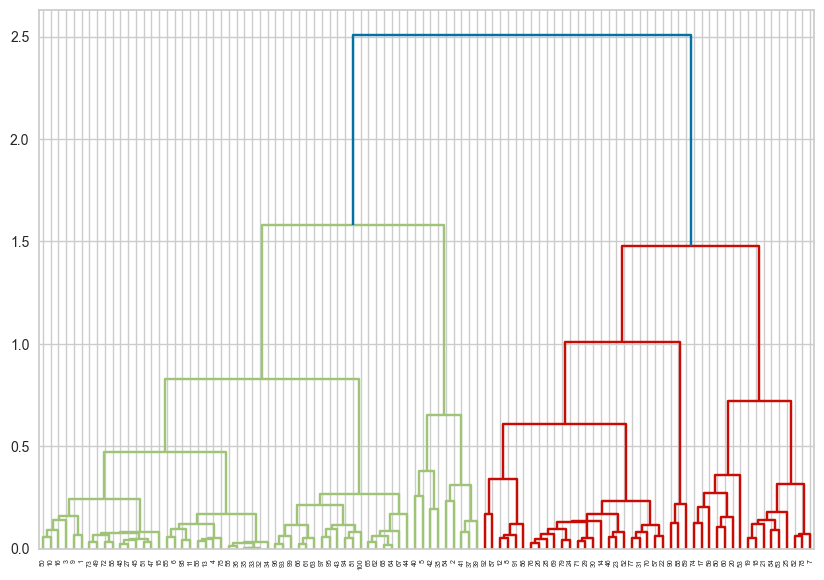

In [263]:
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import numpy as np

# 1. 'hour_by3' 특성 생성
train_df['hour_by3'] = train_df['날짜'].dt.hour // 3 * 3

# 2. & 3. 전력 사용량의 중앙값 및 정규화된 전력 사용량 계산
agg_cl = train_df.groupby(['건물번호', 'hour_by3', '요일']).median().reset_index()
agg_cl['R'] = agg_cl.groupby('건물번호')['전력소비량(kWh)'].transform(lambda x: x / x.max())

# 4. 군집화를 위한 데이터 준비
dt_cl = agg_cl.pivot_table(index='건물번호', columns=['요일', 'hour_by3'], values='R')

# 계층적 군집화 실행
linked = linkage(dt_cl, method='ward')

# 5. 군집화 결과 시각화
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', labels=dt_cl.index.tolist(), distance_sort='descending')
plt.show()


In [334]:
train_df.dtypes

건물번호              int64
기온(C)           float64
강수량(mm)         float64
풍속(m/s)         float64
습도(%)           float64
전력소비량(kWh)      float64
요일                int64
건물유형              int32
연면적(m2)         float64
냉방면적(m2)        float64
태양광용량(kW)       float64
ESS저장용량(kWh)    float64
PCS용량(kW)       float64
일                 int64
월                 int64
불쾌지수            float64
체감온도            float64
sin_time        float64
cos_time        float64
냉방면적비율          float64
기온습도            float64
dtype: object

In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# 가정: 'agg_cl'은 train_df에서 계산된 요일/3시간별 전력 사용량의 중앙값 및 정규화된 전력 사용량을 포함하는 데이터프레임입니다.

# 계층적 군집화
Z = linkage(agg_cl.drop('건물번호', axis=1), method='ward')

# 군집화 결과를 데이터프레임에 추가
num_clusters = 5
labels = fcluster(Z, num_clusters, criterion='maxclust')
dt_cl_result = pd.DataFrame({'건물번호': agg_cl['건물번호'], 'grp': labels})

# 군집 레이블을 'agg_cl'에 추가
agg_cl = agg_cl.merge(dt_cl_result, on='건물번호')

# 각 군집에 대한 평균 계산
mean_values = agg_cl.groupby(['grp', 'hour_by3', '요일'])['R'].mean().reset_index()
mean_values.rename(columns={'R': 'MM'}, inplace=True)

# 시각화
plt.figure(figsize=(14, 8))
sns.heatmap(mean_values.pivot_table(index='요일', columns=['grp', 'hour_by3'], values='MM'), cmap='YlGnBu', annot=True)
plt.show()


KeyError: 'grp'

In [189]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor

def train_blended_models(train_df):
    building_types = train_df['건물유형'].unique()
    models = {}
    
    for building_type in building_types:
        building_data = train_df[train_df['건물유형'] == building_type]
        
        X = building_data.drop("전력사용량(kWh)", axis=1)
        y = building_data["전력사용량(kWh)"]
        
        # Extra Trees Regressor 모델 학습
        et_model = ExtraTreesRegressor(n_estimators=100, random_state=seed)
        et_model.fit(X, y)
        
        # Random Forest Regressor 모델 학습
        rf_model = RandomForestRegressor(n_estimators=100, random_state=seed)
        rf_model.fit(X, y)
        
        models[building_type] = (et_model, rf_model)
        
    return models

def predict_blended(models, test_df):
    building_types = test_df['건물유형'].unique()
    blended_predictions = []
    
    for building_type in building_types:
        building_data = test_df[test_df['건물유형'] == building_type]
        
        et_model, rf_model = models[building_type]
        et_preds = et_model.predict(building_data)
        rf_preds = rf_model.predict(building_data)
        
        # 두 모델의 예측을 평균화
        blended_pred = (et_preds + rf_preds) / 2
        blended_predictions.extend(blended_pred)
        
    return blended_predictions

# sMAPE 평가 지표 정의
def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

smape_score = make_scorer(smape, greater_is_better=False)

def hyperparameter_tuning(model, param_grid, X, y):
    # GridSearchCV를 사용하여 하이퍼파라미터 튜닝
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=smape_score, n_jobs=-1)
    grid_search.fit(X, y)
    
    # 최적의 하이퍼파라미터를 사용한 모델 반환
    return grid_search.best_estimator_

def train_blended_models_tuned(train_df):
    building_types = train_df['건물유형'].unique()
    models = {}
    
    et_param_grid = {
        'n_estimators': [50, 100, 150],
        'max_features': ['auto', 'sqrt'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf_param_grid = {
        'n_estimators': [50, 100, 150],
        'max_features': ['auto', 'sqrt'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    for building_type in building_types:
        building_data = train_df[train_df['건물유형'] == building_type]
        
        X = building_data.drop("전력소비량(kWh)", axis=1)
        y = building_data["전력소비량(kWh)"]
        
        # Extra Trees Regressor 모델 학습
        et_model = ExtraTreesRegressor(random_state=seed)
        et_model_tuned = hyperparameter_tuning(et_model, et_param_grid, X, y)
        
        # Random Forest Regressor 모델 학습
        rf_model = RandomForestRegressor(random_state=seed)
        rf_model_tuned = hyperparameter_tuning(rf_model, rf_param_grid, X, y)
        
        models[building_type] = (et_model_tuned, rf_model_tuned)
        
    return models

def predict_blended(models, test_df):
    building_types = test_df['건물유형'].unique()
    blended_predictions = []
    
    for building_type in building_types:
        building_data = test_df[test_df['건물유형'] == building_type]
        
        et_model, rf_model = models[building_type]
        et_preds = et_model.predict(building_data)
        rf_preds = rf_model.predict(building_data)
        
        # 두 모델의 예측을 평균화
        blended_pred = (et_preds + rf_preds) / 2
        blended_predictions.extend(blended_pred)
        
    return blended_predictions

# 건물 유형별로 두 모델을 학습
blended_models = train_blended_models_tuned(train_df)

# 학습된 모델로 테스트 데이터에 대한 예측 수행
blended_predictions = predict_blended(blended_models, test_df)

# 제출 파일 템플릿 로드
sample_submission = pd.read_csv('./sample_submission.csv')

# 예측값 저장
sample_submission['answer'] = blended_predictions
sample_submission.to_csv("./sample_submission.csv", index=False)


In [190]:
sample_submission.head(10)

,num_date_time,answer
0,1_20220825 00,1835.564446
1,1_20220825 01,1843.336129
2,1_20220825 02,1753.811878
3,1_20220825 03,1672.622015
4,1_20220825 04,1659.221519
5,1_20220825 05,1763.993494
6,1_20220825 06,1865.902768
7,1_20220825 07,2071.983151
8,1_20220825 08,2632.935630
9,1_20220825 09,2947.346840


In [43]:
def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output


In [44]:
train_df.columns

Index(['건물번호', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '전력소비량(kWh)', '요일',
       '공휴일', '건물유형', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)',
       'PCS용량(kW)', '일', '월', '불쾌지수', '체감온도', 'sin_time', 'cos_time', '냉방면적비율',
       '기온습도'],
      dtype='object')

In [45]:
# Define features and target again after preprocessing
X = train_df.drop('전력소비량(kWh)', axis=1)
y = train_df['전력소비량(kWh)']
model = setup(X, target = y, session_id=seed )
# SMAPE를 pycaret 지표로 추가
from pycaret.regression import add_metric
add_metric('smape', 'SMAPE', smape, greater_is_better=False)

,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(204000, 22)"
4,Transformed data shape,"(204000, 22)"
5,Transformed train set shape,"(142800, 22)"
6,Transformed test set shape,"(61200, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


Name                                                       SMAPE
Display Name                                               SMAPE
Score Function            <function smape at 0x00000238AFD3DCA0>
Scorer               make_scorer(smape, greater_is_better=False)
Target                                                      pred
Args                                                          {}
Greater is Better                                          False
Custom                                                      True
Name: smape, dtype: object

In [46]:
top5_models = compare_models(fold = 5, round = 3, sort = 'smape', n_select = 4)
top5_models
print(pull())

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,75.564,19836.676,140.837,0.997,0.081,0.069,4.103,5.220
rf,Random Forest Regressor,85.068,24817.725,157.529,0.996,0.086,0.072,4.503,8.522
dt,Decision Tree Regressor,110.718,47312.066,217.484,0.992,0.118,0.091,5.794,0.314
catboost,CatBoost Regressor,144.420,48446.362,220.068,0.992,0.142,0.119,8.624,4.620
xgboost,Extreme Gradient Boosting,163.296,58139.455,241.089,0.990,0.170,0.127,9.920,1.600
lightgbm,Light Gradient Boosting Machine,223.793,100325.041,316.732,0.983,0.192,0.175,12.981,0.302
knn,K Neighbors Regressor,503.690,669278.325,818.039,0.888,0.370,0.314,24.495,1.772
gbr,Gradient Boosting Regressor,528.210,508281.549,712.928,0.915,0.380,0.389,27.088,3.538
lasso,Lasso Regression,1318.384,5141003.000,2266.936,0.139,0.717,0.814,52.067,0.902
ridge,Ridge Regression,1314.732,5135829.700,2265.793,0.140,0.725,0.813,52.234,0.516


Processing:   0%|          | 0/88 [00:00<?, ?it/s]

                                    Model         MAE           MSE  \
et                  Extra Trees Regressor      75.564  1.983668e+04   
rf                Random Forest Regressor      85.068  2.481772e+04   
dt                Decision Tree Regressor     110.718  4.731207e+04   
catboost               CatBoost Regressor     144.420  4.844636e+04   
xgboost         Extreme Gradient Boosting     163.296  5.813946e+04   
lightgbm  Light Gradient Boosting Machine     223.793  1.003250e+05   
knn                 K Neighbors Regressor     503.690  6.692783e+05   
gbr           Gradient Boosting Regressor     528.210  5.082815e+05   
lasso                    Lasso Regression    1318.384  5.141003e+06   
ridge                    Ridge Regression    1314.732  5.135830e+06   
llar         Lasso Least Angle Regression    1357.354  5.276974e+06   
lr                      Linear Regression    1362.467  5.330011e+06   
en                            Elastic Net    1382.624  5.374047e+06   
huber 

In [47]:
total_models = []
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [48]:
et = create_model('et', fold=10)
total_models.append(et)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,72.6726,19064.1140,138.0729,0.9968,0.0765,0.0415,3.9517
1,73.6329,19632.2028,140.1150,0.9968,0.0810,0.0429,4.0783
2,73.3229,17927.5531,133.8938,0.9971,0.0763,0.0413,3.9731
3,74.6651,19104.6590,138.2196,0.9969,0.0803,0.0423,4.0115
4,74.5491,19548.7665,139.8169,0.9967,0.0787,0.0425,4.0730
5,71.7257,17953.0290,133.9889,0.9970,0.0952,0.3001,3.9088
6,73.6478,18947.0872,137.6484,0.9969,0.0739,0.0406,3.9474
7,72.8615,17617.4156,132.7306,0.9971,0.0745,0.0409,3.9410
8,73.8564,18662.1046,136.6093,0.9966,0.0775,0.0422,4.0458


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [49]:
rf = create_model('rf', fold = 10)
total_models.append(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,80.8977,23013.8583,151.7032,0.9962,0.0808,0.0454,4.3207
1,82.0902,23012.8143,151.6998,0.9962,0.0850,0.0468,4.4434
2,81.6877,22264.6861,149.2136,0.9965,0.0810,0.0452,4.3183
3,83.2299,23292.4570,152.6187,0.9962,0.0842,0.0461,4.3858
4,82.9126,23508.4348,153.3246,0.9960,0.0819,0.0459,4.3855
5,81.4014,22472.1000,149.9070,0.9963,0.0991,0.2928,4.3209
6,82.4554,23466.3865,153.1874,0.9962,0.0783,0.0445,4.3014
7,82.3197,22854.7369,151.1778,0.9963,0.0805,0.0452,4.3363
8,83.1914,24450.1739,156.3655,0.9956,0.0836,0.0466,4.4419


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [26]:
dt = create_model('dt', fold = 10)
total_models.append(dt)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,188.0539,245046.4966,495.0217,0.9595,0.1973,0.0928,8.6470
1,189.4931,245009.4917,494.9843,0.9596,0.1878,0.0953,8.8526
2,191.4013,258120.1185,508.0552,0.9589,0.1941,0.0936,8.7622
3,190.4585,234375.3794,484.1233,0.9616,0.1855,0.0948,8.7638
4,194.4772,251495.1205,501.4929,0.9570,0.1896,0.0952,9.0336
5,188.2484,246247.4469,496.2333,0.9591,0.1920,0.3144,8.7145
6,192.0453,254213.2338,504.1956,0.9588,0.1836,0.0940,8.7027
7,191.0672,229080.1081,478.6231,0.9625,0.1882,0.0957,8.9096
8,189.0836,225403.4910,474.7668,0.9592,0.1842,0.0940,8.8861


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [27]:
catboost = create_model('catboost', fold = 10)
total_models.append(catboost)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,234.0719,156165.8399,395.1782,0.9742,0.2027,0.1340,12.4430
1,232.5085,151668.0478,389.4458,0.9750,0.1964,0.1356,12.4004
2,235.3689,164009.6791,404.9811,0.9739,0.1938,0.1332,12.2484
3,241.1145,167561.8075,409.3431,0.9725,0.1938,0.1358,12.4029
4,235.2852,157870.4339,397.3291,0.9730,0.1902,0.1327,12.2889
5,228.5764,145779.7277,381.8111,0.9758,0.1969,0.4311,12.1209
6,234.3029,155012.0882,393.7157,0.9749,0.1899,0.1304,12.1544
7,232.7108,155712.7803,394.6046,0.9745,0.1960,0.1320,12.1950
8,232.9492,154045.9174,392.4868,0.9721,0.1937,0.1318,12.2589


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [71]:
expanded_param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False]
}


# Tune the model
tuned_et = tune_model(et, custom_grid=expanded_param_grid, search_library='optuna', search_algorithm='tpe', n_iter=10, fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,83.6314,28137.7242,167.7430,0.9954,0.0889,0.0481,4.5036
1,84.4457,26459.4183,162.6635,0.9957,0.0890,0.0478,4.4746
2,83.8786,27418.5809,165.5856,0.9954,0.0948,0.1767,4.4676
3,84.5905,29413.6502,171.5041,0.9952,0.0856,0.0467,4.4221
4,83.1911,25430.0431,159.4680,0.9954,0.0840,0.0469,4.4472
Mean,83.9475,27371.8833,165.3928,0.9954,0.0885,0.0732,4.4630
Std,0.5174,1368.2719,4.1343,0.0002,0.0037,0.0517,0.0273


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

[I 2023-08-15 14:42:38,888] Searching the best hyperparameters using 142800 samples...
[I 2023-08-15 14:45:26,696] Finished hyperparemeter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [72]:
# Tune the model
tuned_rf = tune_model(rf, custom_grid=expanded_param_grid, search_library='optuna', search_algorithm='tpe', n_iter=10, fold=5)


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,87.9914,29256.0910,171.0441,0.9952,0.0890,0.0495,4.6734
1,89.2614,29769.2366,172.5376,0.9952,0.0885,0.0488,4.6261
2,88.9090,31937.2930,178.7101,0.9946,0.0941,0.1711,4.6214
3,90.3655,34715.8922,186.3220,0.9943,0.0875,0.0487,4.6272
4,88.0941,29156.1527,170.7517,0.9947,0.0858,0.0486,4.6333
Mean,88.9243,30966.9331,175.8731,0.9948,0.0890,0.0734,4.6363
Std,0.8661,2127.7536,5.9649,0.0003,0.0028,0.0489,0.0190


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

[I 2023-08-15 14:46:13,504] Searching the best hyperparameters using 142800 samples...
[I 2023-08-15 14:53:36,556] Finished hyperparemeter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [27]:
boosted_rf = ensemble_model(rf, fold = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,93.7082,32905.6455,181.3991,0.9946,0.0916,0.0524,4.9189
1,92.8987,30043.9474,173.3319,0.9950,0.0940,0.0531,4.9931
2,93.7398,31987.1507,178.8495,0.9949,0.0918,0.0519,4.8836
3,96.9269,35294.2768,187.8677,0.9942,0.0951,0.0531,4.9864
4,95.7826,35957.7690,189.6253,0.9939,0.0910,0.0524,4.9506
5,94.0101,35000.8378,187.0851,0.9942,0.1059,0.3000,4.8601
6,95.3181,35224.8669,187.6829,0.9943,0.0891,0.0510,4.8556
7,96.5005,39413.1303,198.5274,0.9935,0.0927,0.0524,4.9221
8,94.9562,32052.2872,179.0315,0.9942,0.0908,0.0526,4.9826


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [28]:
boosted_et = ensemble_model(et, fold=10)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:31:11
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Bagging Regressor


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\_parallel_backends.py", line 273, in _wrap_func_call
    return func()
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 588, in __call__
    return [func(*args, **kwargs)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 588, in <listcomp>
    return [func(*args, **kwargs)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\utils\parallel.py", line 123, in __call__
    return self.function(*args, **kwargs)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\ensemble\_forest.py", line 186, in _parallel_build_trees
    tree.fit(X, y, sample_weight=sample_weight, check_input=False)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\tree\_classes.py", line 1247, in fit
    super().fit(
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\tree\_classes.py", line 379, in fit
    builder.build(self.tree_, X, y, sample_weight)
  File "sklearn\tree\_tree.pyx", line 147, in sklearn.tree._tree.DepthFirstTreeBuilder.build
  File "sklearn\tree\_tree.pyx", line 242, in sklearn.tree._tree.DepthFirstTreeBuilder.build
  File "sklearn\tree\_tree.pyx", line 748, in sklearn.tree._tree.Tree._add_node
  File "sklearn\tree\_tree.pyx", line 719, in sklearn.tree._tree.Tree._resize_c
  File "sklearn\tree\_utils.pyx", line 35, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 14680064 bytes
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\pycaret\internal\pipeline.py", line 260, in fit
    fitted_estimator = self._memory_fit(
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\memory.py", line 655, in __call__
    return self._cached_call(args, kwargs)[0]
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\pycaret\internal\memory.py", line 398, in _cached_call
    out, metadata = self.call(*args, **kwargs)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\pycaret\internal\memory.py", line 309, in call
    output = self.func(*args, **kwargs)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\pycaret\internal\pipeline.py", line 66, in _fit_one
    transformer.fit(*args, **fit_params)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\ensemble\_bagging.py", line 337, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\ensemble\_bagging.py", line 472, in _fit
    all_results = Parallel(
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\utils\parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 1855, in __call__
    return output if self.return_generator else list(output)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 1784, in _get_sequential_output
    res = func(*args, **kwargs)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\utils\parallel.py", line 123, in __call__
    return self.function(*args, **kwargs)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\ensemble\_bagging.py", line 141, in _parallel_build_estimators
    estimator_fit(X_, y, sample_weight=curr_sample_weight)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\ensemble\_forest.py", line 473, in fit
    trees = Parallel(
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\utils\parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 1944, in __call__
    return output if self.return_generator else list(output)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 1587, in _get_outputs
    yield from self._retrieve()
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 1691, in _retrieve
    self._raise_error_fast()
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 1726, in _raise_error_fast
    error_job.get_result(self.timeout)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 735, in get_result
    return self._return_or_raise()
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 753, in _return_or_raise
    raise self._result
MemoryError: could not allocate 14680064 bytes

--------------------------------------------------------------------------------
6 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\_parallel_backends.py", line 273, in _wrap_func_call
    return func()
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 588, in __call__
    return [func(*args, **kwargs)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 588, in <listcomp>
    return [func(*args, **kwargs)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\utils\parallel.py", line 123, in __call__
    return self.function(*args, **kwargs)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\ensemble\_forest.py", line 186, in _parallel_build_trees
    tree.fit(X, y, sample_weight=sample_weight, check_input=False)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\tree\_classes.py", line 1247, in fit
    super().fit(
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\tree\_classes.py", line 379, in fit
    builder.build(self.tree_, X, y, sample_weight)
  File "sklearn\tree\_tree.pyx", line 147, in sklearn.tree._tree.DepthFirstTreeBuilder.build
  File "sklearn\tree\_tree.pyx", line 242, in sklearn.tree._tree.DepthFirstTreeBuilder.build
  File "sklearn\tree\_tree.pyx", line 748, in sklearn.tree._tree.Tree._add_node
  File "sklearn\tree\_tree.pyx", line 719, in sklearn.tree._tree.Tree._resize_c
  File "sklearn\tree\_utils.pyx", line 35, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 7340032 bytes
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\pycaret\internal\pipeline.py", line 260, in fit
    fitted_estimator = self._memory_fit(
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\memory.py", line 655, in __call__
    return self._cached_call(args, kwargs)[0]
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\pycaret\internal\memory.py", line 398, in _cached_call
    out, metadata = self.call(*args, **kwargs)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\pycaret\internal\memory.py", line 309, in call
    output = self.func(*args, **kwargs)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\pycaret\internal\pipeline.py", line 66, in _fit_one
    transformer.fit(*args, **fit_params)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\ensemble\_bagging.py", line 337, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\ensemble\_bagging.py", line 472, in _fit
    all_results = Parallel(
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\utils\parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 1855, in __call__
    return output if self.return_generator else list(output)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 1784, in _get_sequential_output
    res = func(*args, **kwargs)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\utils\parallel.py", line 123, in __call__
    return self.function(*args, **kwargs)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\ensemble\_bagging.py", line 141, in _parallel_build_estimators
    estimator_fit(X_, y, sample_weight=curr_sample_weight)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\ensemble\_forest.py", line 473, in fit
    trees = Parallel(
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\utils\parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 1944, in __call__
    return output if self.return_generator else list(output)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 1587, in _get_outputs
    yield from self._retrieve()
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 1691, in _retrieve
    self._raise_error_fast()
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 1726, in _raise_error_fast
    error_job.get_result(self.timeout)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 735, in get_result
    return self._return_or_raise()
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 753, in _return_or_raise
    raise self._result
MemoryError: could not allocate 7340032 bytes

--------------------------------------------------------------------------------
1 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\_parallel_backends.py", line 273, in _wrap_func_call
    return func()
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 588, in __call__
    return [func(*args, **kwargs)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 588, in <listcomp>
    return [func(*args, **kwargs)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\utils\parallel.py", line 123, in __call__
    return self.function(*args, **kwargs)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\ensemble\_forest.py", line 186, in _parallel_build_trees
    tree.fit(X, y, sample_weight=sample_weight, check_input=False)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\tree\_classes.py", line 1247, in fit
    super().fit(
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\tree\_classes.py", line 379, in fit
    builder.build(self.tree_, X, y, sample_weight)
  File "sklearn\tree\_tree.pyx", line 147, in sklearn.tree._tree.DepthFirstTreeBuilder.build
  File "sklearn\tree\_tree.pyx", line 242, in sklearn.tree._tree.DepthFirstTreeBuilder.build
  File "sklearn\tree\_tree.pyx", line 748, in sklearn.tree._tree.Tree._add_node
  File "sklearn\tree\_tree.pyx", line 719, in sklearn.tree._tree.Tree._resize_c
  File "sklearn\tree\_utils.pyx", line 35, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 3670016 bytes
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\pycaret\internal\pipeline.py", line 260, in fit
    fitted_estimator = self._memory_fit(
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\memory.py", line 655, in __call__
    return self._cached_call(args, kwargs)[0]
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\pycaret\internal\memory.py", line 398, in _cached_call
    out, metadata = self.call(*args, **kwargs)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\pycaret\internal\memory.py", line 309, in call
    output = self.func(*args, **kwargs)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\pycaret\internal\pipeline.py", line 66, in _fit_one
    transformer.fit(*args, **fit_params)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\ensemble\_bagging.py", line 337, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\ensemble\_bagging.py", line 472, in _fit
    all_results = Parallel(
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\utils\parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 1855, in __call__
    return output if self.return_generator else list(output)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 1784, in _get_sequential_output
    res = func(*args, **kwargs)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\utils\parallel.py", line 123, in __call__
    return self.function(*args, **kwargs)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\ensemble\_bagging.py", line 141, in _parallel_build_estimators
    estimator_fit(X_, y, sample_weight=curr_sample_weight)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\ensemble\_forest.py", line 473, in fit
    trees = Parallel(
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\sklearn\utils\parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 1944, in __call__
    return output if self.return_generator else list(output)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 1587, in _get_outputs
    yield from self._retrieve()
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 1691, in _retrieve
    self._raise_error_fast()
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 1726, in _raise_error_fast
    error_job.get_result(self.timeout)
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 735, in get_result
    return self._return_or_raise()
  File "c:\Users\MYPC\anaconda3\envs\newpycaret\lib\site-packages\joblib\parallel.py", line 753, in _return_or_raise
    raise self._result
MemoryError: could not allocate 3670016 bytes


In [50]:
blender3 = blend_models(estimator_list=[et,rf])

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,74.3086,19518.9954,139.7104,0.9968,0.0767,0.0422,4.0180
1,75.2753,19670.1321,140.2502,0.9968,0.0810,0.0436,4.1399
2,75.0568,18548.0726,136.1913,0.9970,0.0767,0.0420,4.0293
3,76.4410,19580.9852,139.9321,0.9968,0.0804,0.0430,4.0868
4,76.2242,19918.0375,141.1313,0.9966,0.0783,0.0430,4.1084
5,74.0393,18628.3297,136.4856,0.9969,0.0954,0.2952,3.9908
6,75.4567,19522.8187,139.7241,0.9968,0.0739,0.0413,4.0034
7,74.9029,18541.9189,136.1687,0.9970,0.0755,0.0418,4.0167
8,76.0033,19995.7399,141.4063,0.9964,0.0784,0.0432,4.1224


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [54]:
stacker = stack_models([et, rf])

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,163.5041,123429.3042,351.3251,0.9796,0.1381,0.0825,7.4766
1,162.2330,124706.9664,353.1387,0.9794,0.1407,0.0833,7.5083
2,167.0386,136357.0038,369.2655,0.9783,0.1389,0.0824,7.4799
3,169.4412,134588.1152,366.8625,0.9779,0.1428,0.0842,7.5976
4,165.5689,135970.5041,368.7418,0.9768,0.1374,0.0817,7.4730
5,159.5315,114714.7884,338.6957,0.9809,0.1479,0.3287,7.3150
6,168.1757,134517.9622,366.7669,0.9782,0.1377,0.0816,7.4571
7,164.1453,122682.6139,350.2608,0.9799,0.1353,0.0806,7.3854
8,163.0373,117623.4419,342.9627,0.9787,0.1382,0.0820,7.4783


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [51]:
final_model = finalize_model(et) # 모델 선택

In [52]:
prediction = predict_model(final_model, data = test_df)
prediction.head()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),요일,공휴일,건물유형,연면적(m2),냉방면적(m2),...,PCS용량(kW),일,월,불쾌지수,체감온도,sin_time,cos_time,냉방면적비율,기온습도,prediction_label
0,1,23.500000,0.0,2.2,72,4,0,0,110634.0,39570.0,...,0.0,25,8,71.789803,25.397062,0.000000,1.000000,0.357666,1692.000000,2028.537610
1,1,23.000000,0.0,0.9,72,4,0,0,110634.0,39570.0,...,0.0,25,8,71.028397,25.201620,0.258819,0.965926,0.357666,1656.000000,2147.716783
2,1,22.700001,0.0,1.5,75,4,0,0,110634.0,39570.0,...,0.0,25,8,70.816750,24.699787,0.500000,0.866025,0.357666,1702.500000,1969.924817
3,1,22.100000,0.0,1.3,78,4,0,0,110634.0,39570.0,...,0.0,25,8,70.112617,24.136019,0.707107,0.707107,0.357666,1723.800049,1928.908812
4,1,21.799999,0.0,1.0,77,4,0,0,110634.0,39570.0,...,0.0,25,8,69.565140,23.942400,0.866025,0.500000,0.357666,1678.599976,1911.777605


In [53]:
submission = pd.read_csv('./sample_submission.csv')
submission['answer'] = prediction['prediction_label']
submission

,num_date_time,answer
0,1_20220825 00,2028.537610
1,1_20220825 01,2147.716783
2,1_20220825 02,1969.924817
3,1_20220825 03,1928.908812
4,1_20220825 04,1911.777605
...,...,...
16795,100_20220831 19,878.987990
16796,100_20220831 20,794.178610
16797,100_20220831 21,796.843195
16798,100_20220831 22,625.840211


In [54]:
submission.head()

,num_date_time,answer
0,1_20220825 00,2028.537610
1,1_20220825 01,2147.716783
2,1_20220825 02,1969.924817
3,1_20220825 03,1928.908812
4,1_20220825 04,1911.777605


In [55]:
submission.to_csv('./sample_submission.csv', index=False)

883050 sample_submission.csv ->     2023-08-04 22:56:28	  
점수 :  11.3106350099    
882357	baseline_submission.csv -> 기본 베이스라인    
점수 :  11.4272466862      
883068	sample_submission.csv -> 냉방면적비율, 기온 * 습도   
점수 :  11.0962158216   
883089  sample_submission.csv -> rf,et두개 튜닝 없이 blend, 위의 피처 유지   
점수 :  10.5175166528  
883972	sample_submission.csv -> rf, et, dt 3개 튜닝 없이 blend, 피처 유지  
점수 :  11.0865256548   
883996	sample_submission.csv -> rf boosting   
점수 :  10.7427858361   
884099	sample_submission.csv -> 일사, 일조 저녁 NaN처리, rf 사용  
점수 :  11.1980426119   
884104	sample_submission.csv -> rf, et blend  
점수 :  10.6167324479   
884131	sample_submission.csv -> rf boosting  
점수 :  10.783522939  

### 밤 시간대는 0, 낮은 선형 보간 및 양쪽 값으로 일조, 일사 결측치 채움   
rf   
점수 :  11.0883508279  
rf, et blend  
점수 :  10.522504182  
rf boosting  
점수 :  10.7291229483  
   

### 위처럼 일조, 일사 결측치 채우고, 그걸 바탕으로 강수량 예측
rf,et blend  
점수 :  10.540390791  

### 요일 피처 추가
rf 기본  
점수 :  7.4544912328  
rf, et blend  
점수 :  6.9199422558  
냉방면적비율, 기온 * 습도  빼고 rf,et blend  
점수 :   7.36226581   

### 불쾌지수, CDH 추가
rf, et blend  
점수 :  6.3979091115  

### 불쾌지수만 존재
rf, et blend  
점수 :  6.367099545  
### 위에서 시간을 sin, cos으로 cyclical encoding  
rf, et blend  
점수 :  6.2856003051  
### 태양광 어쩌구 그런 3개 drop  
rf, et blend   
점수 :  6.3280580332    
### 월도 cyclical encoding 
rf, et blend  
점수 :  6.3893016345   
### 불쾌지수+ 체감온도, 시간 cyclical encoding  
rf, et blend   
점수 :  6.285046579   
###  불쾌지수+ 체감온도, 시간 cyclical encoding, 8/15,6/6제외  
rf, et blend   
점수 :  6.2359877094    
### 공휴일 피처 추가
rf, et blend  
점수 :  6.3411322448    

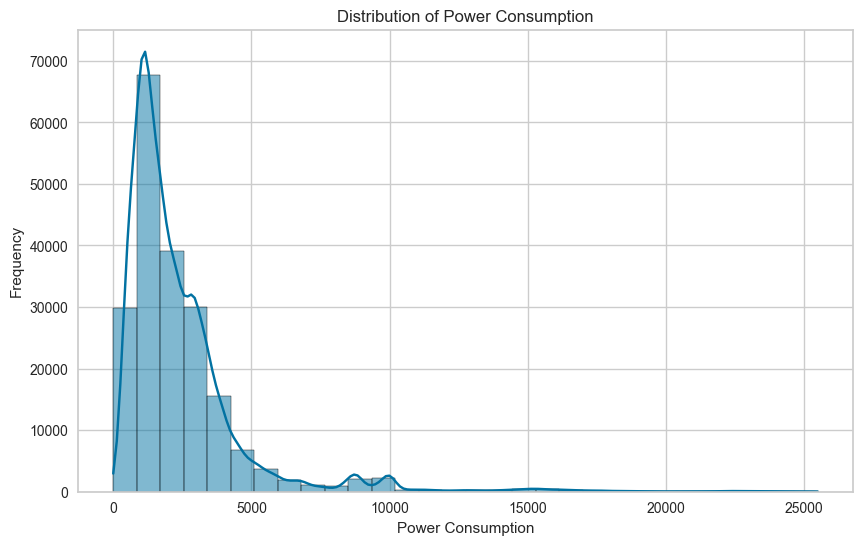

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
# histogram 생성
plt.figure(figsize=(10, 6))
sns.histplot(train_df['전력소비량(kWh)'], bins=30, kde=True)
plt.title('Distribution of Power Consumption')
plt.xlabel('Power Consumption')
plt.ylabel('Frequency')
plt.show()

In [53]:
test_df.head()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),시,일,월
0,1,23.5,0.0,2.2,72,0,25,8
1,1,23.0,0.0,0.9,72,1,25,8
2,1,22.7,0.0,1.5,75,2,25,8
3,1,22.1,0.0,1.3,78,3,25,8
4,1,21.8,0.0,1.0,77,4,25,8


In [7]:
building_info.head()

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000


In [8]:
building_info['건물유형'].unique()

array(['건물기타', '공공', '대학교', '데이터센터', '백화점및아울렛', '병원', '상용', '아파트', '연구소',
       '지식산업센터', '할인마트', '호텔및리조트'], dtype=object)

In [12]:
building_info.isnull().sum()

건물번호            0
건물유형            0
연면적(m2)         0
냉방면적(m2)        0
태양광용량(kW)       0
ESS저장용량(kWh)    0
PCS용량(kW)       0
dtype: int64

In [13]:
train_df.isnull().sum()

num_date_time         0
건물번호                  0
일시                    0
기온(C)                 0
강수량(mm)          160069
풍속(m/s)              19
습도(%)                 9
일조(hr)            75182
일사(MJ/m2)         87913
전력소비량(kWh)            0
dtype: int64

In [25]:
(train_df['일조(hr)'].isna()&train_df['일사(MJ/m2)'].notna()).sum()

1

일조 데이터가 null이면서 일사 데이터가 null이 아닌 데이터는 한개뿐

In [26]:
(train_df['일조(hr)'].isna()&train_df['일사(MJ/m2)'].isna()).sum()

75181